In [31]:
import sys
sys.path.append('/Users/murlidhar.4/Documents/Projects/microlens/triplelens-1.0.7/test/')
from utils import plot_critcaus_srcimgs, pltlkv
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
import TripleLensing
TRIL = TripleLensing.TripleLensing()
import MulensModel as mm
import numpy as np

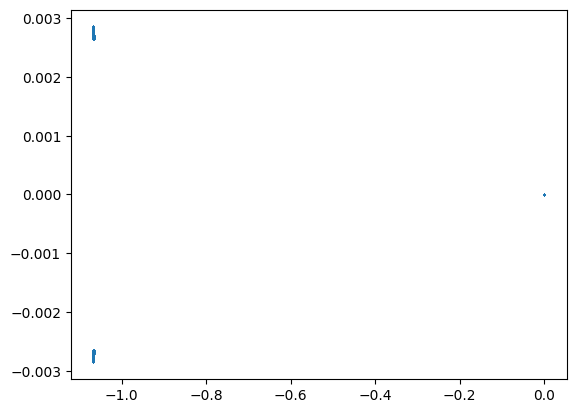

In [190]:
binarycaus = mm.Caustics(s=0.6, q=1e-6)
binarycaus.plot(s=1)
#print(binarycaus.get_caustics())

### calculate the finite source magnification at a single source position

Binary star and planet - physical parameters to microlensing parameters

In [24]:
import astropy.units as u
import astropy.constants as const
q2 = 0.925
s = 0.4
m1 = 1*u.M_sun #Mass of primary in units of solar mass
m2 = q2*m1 #Mass of secondary in units of solar mass
Ds = 8*u.kpc #Distance to source in kpc
Dl = 4*u.kpc #Distance to lens in kpc
Dls = Ds-Dl
Drel = Ds*Dl/Dls
Drel = Drel.to(u.m)
theta_E = np.sqrt(4.*const.G*(m1.to(u.kg)+m2.to(u.kg))/(const.c**2*Drel))#Einstein radius in radians
#(theta_E*u.rad).to(u.mas)
r_E = Dl*theta_E
r_E = r_E.to(u.AU)
a = r_E*s #Projected binary lens separation in AU
P = 2*np.pi*np.sqrt(a.to(u.m)**3/(const.G*(m1.to(u.kg)+m2.to(u.kg)))) #Orbital period in seconds


#Planet physical parameters
mp = 1e-5*u.M_sun #Mass of planet in units of solar mass
sp = 0.9560
ap = sp*r_E
Pplanet = 2*np.pi*np.sqrt(ap.to(u.m)**3/(const.G*(m1.to(u.kg)+m2.to(u.kg))))
Pplanet = Pplanet.to(u.yr)






In [25]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import FloatSlider, FloatLogSlider
from IPython.display import display
import MulensModel as mm
import VBMicrolensing

# Fixed binary parameters (circumbinary host)
s2_fixed = 0.2
q2_fixed = 0.925

# Plot limits and styling
X_MIN, X_MAX = -0.5, 0.5
Y_MIN, Y_MAX = -0.5, 1.0


def plot_circumbinary_caustics(s3: float, q3: float, psi_deg: float):
    psi = np.deg2rad(psi_deg)

    # Masses normalized so that total binary mass = 1
    m1 = 1.0 / (1.0 + q2_fixed)
    m2 = q2_fixed * m1
    m3 = q3 * m1

    # Lens positions (binary along x, planet offset by s3 at angle psi)
    z1x = -q2_fixed * s2_fixed / (1.0 + q2_fixed)
    z2x = s2_fixed / (1.0 + q2_fixed)
    z3x = -q2_fixed * s2_fixed / (1.0 + q2_fixed) + s3 * np.cos(psi)
    z3y = s3 * np.sin(psi)

    # Configure VBMicrolensing for triple-lens caustics
    VBM = VBMicrolensing.VBMicrolensing()
    VBM.Tol = 1e-4
    VBM.SetMethod(VBM.Method.Multipoly)
    vbm_params = [
        z1x, 0.0, m1,  # lens 1 (x, y, m)
        z2x, 0.0, m2,  # lens 2
        z3x, z3y, m3,  # lens 3 (planet)
    ]
    VBM.SetLensGeometry(vbm_params)
    caustics = VBM.Multicaustics()

    # Planetary caustic (relative to planet position and orientation)
    splanet = np.hypot(z3x, z3y)
    qplanet = m3 / (m1 + m2)
    planet_caustic = mm.Caustics(s=splanet, q=qplanet)
    px, py = planet_caustic.get_caustics()
    px, py = np.array(px), np.array(py)
    planetorient = np.arctan2(z3y, z3x)
    if planetorient < 0:
        planetorient += 2.0 * np.pi
    pxr = px * np.cos(planetorient) - py * np.sin(planetorient)
    pyr = px * np.sin(planetorient) + py * np.cos(planetorient)

    # Binary-only caustic for reference
    binary_caustic = mm.Caustics(s=s2_fixed, q=q2_fixed)
    bx, by = binary_caustic.get_caustics()

    # Draw figure
    fig = plt.figure(figsize=(5, 5), dpi=150)
    ax = fig.add_subplot(1, 1, 1)
    plt.subplots_adjust(top=0.9, bottom=0.08, right=0.95, left=0.1, hspace=0.1, wspace=0.2)

    ax.set_xlim(X_MIN, X_MAX)
    ax.set_ylim(Y_MIN, Y_MAX)
    x_left, x_right = ax.get_xlim()
    y_low, y_high = ax.get_ylim()
    ax.set_aspect(abs((x_right - x_left) / (y_high - y_low)))

    # Plot lenses
    ax.scatter([z1x, z2x], [0.0, 0.0], marker='o', s=8, color='goldenrod', label='Binary lenses')
    ax.scatter([z3x], [z3y], marker='o', s=8, color='black', label='Planet lens')

    # Plot caustics
    for cau in caustics:
        ax.plot(cau[0], cau[1], 'k', alpha=1.0, linewidth=0.8)
    ax.scatter(pxr, pyr, marker='.', s=0.1, color='green', alpha=0.3, label='Planet caustic')
    ax.scatter(bx, by, marker='.', s=0.1, color='blue', alpha=0.3, label='Binary caustic')

    # Legend and title
    ax.legend(loc='upper left', fontsize=8)
    ax.set_title(f's3={s3:.3f}, q3={q3:.2e}, psi={psi_deg:.1f}°  |  s2={s2_fixed:.2f}, q2={q2_fixed:.3f}')
    plt.show()


# Sliders
s3_slider = FloatSlider(value=0.9, min=0.05, max=2.5, step=0.01, description='s3')
q3_slider = FloatLogSlider(value=1e-3, base=10, min=-8, max=-1, step=0.01, description='q3')  # 1e-8 .. 1e-1
psi_slider = FloatSlider(value=60.0, min=0.0, max=360.0, step=1.0, description='psi (deg)')

ui = widgets.VBox([s3_slider, q3_slider, psi_slider])
out = widgets.interactive_output(
    plot_circumbinary_caustics, {"s3": s3_slider, "q3": q3_slider, "psi_deg": psi_slider}
)

display(ui, out)


Output()

### plot caustics and critical curve

Caustics - VB Microlensing

In [ ]:
import sys
sys.path.append('/Users/murlidhar.4/Documents/Projects/microlens/triplelens-1.0.7/test/')
from utils import plot_critcaus_srcimgs, pltlkv
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
import TripleLensing
TRIL = TripleLensing.TripleLensing()
import MulensModel as mm
import numpy as np
import seaborn as sns
import os
from time import time

#meausre the time taken to run this function
start = time()
t0, u0, tE, s2, q2, alpha, s3, q3, psi, rs = 2000., -0.01, 30., 0.2, 0.925, 126.*np.pi/180., 0.9, 1.0*1e-5, 60.0*np.pi/180. , 1e-3
salpha = np.sin(alpha)
calpha = np.cos(alpha)
params = [t0, u0, tE, s2, q2, alpha, s3, q3, psi, rs]
psideg = psi*180./np.pi
#set up lens system
m1 = 1./(1. + q2) #Normalized so that total mass of binary=1. VBMicrolensing - coordinates are in units of Einstein radius for a unitary mass lens
m2 = q2 * m1
m3 = q3 * m1
z1x = -q2*s2/(1. + q2)
z2x = s2/(1. + q2)
z3x = -q2*s2/(1. + q2) + s3*np.cos(psi)
z3y = s3*np.sin(psi)
mlens = [m1, m2, m3]
zlens = [z1x,0.,z2x,0.,z3x,z3y]
number = "1"
gamma = (75./2.)/tE
# source position
ts = np.linspace(t0 - gamma*tE, t0 + gamma*tE, int(2.*gamma*tE*1440./15.))
tsdash = np.linspace(t0 - 5.*tE, t0 + 5.*tE, 10000)
tn = (ts - t0) / tE
tndash = (tsdash - t0) / tE
y1s = u0 * salpha + tn * calpha # source positions
y2s = u0 * calpha - tn * salpha
y1straj = u0 * salpha + tndash * calpha #source positions for source trajectory
y2straj = u0 * calpha - tndash * salpha

#parameters controls the accuracy of finite source calculation
secnum = 120 # divide the source bondary into how many parts
basenum = 5 # the number density of sampled dots among each part
quaderr_Tol = 1e-2 # the Quadrupole test tolerance
relerr_Tol = 1e-2 # the relative error tolerance for magnification

#planet orientation (planet at planet position, star at origin)
splanet = np.sqrt(z3x**2 + z3y**2)
qplanet = m3/(m1+m2)
alphamulens = (2.0*np.pi - alpha)*180./np.pi
planetcom = np.array([(m3*z3x)/(m1+m2+m3),(m3*z3y)/(m1+m2+m3)]) #Position of COM of planet and star
planetcomdist = np.sqrt(planetcom[0]**2 + planetcom[1]**2)
u0planet = np.abs(planetcom[0]*salpha + planetcom[1]*calpha - u0)*np.sign(u0) #impact parameter of planet
slopep = z3y/z3x
slopet = -np.tan(alpha)
beta = np.arctan(np.abs((slopep - slopet)/(1. + slopep*slopet)))
print(round(np.abs(u0planet - u0),6),round(planetcomdist*np.sin(beta),6))

if z3y > 0:
    planetorient = np.arctan2(z3y,z3x)
elif z3y == 0:
    if z3x > 0:
        planetorient = 0.
    elif z3x < 0:
        planetorient = np.pi
else:
    planetorient = 2*np.pi + np.arctan2(z3y,z3x)
alphaplanet = alphamulens - planetorient*180./np.pi
print("splanet = %.4f, qplanet = %.7f, planetcomdist = %.5f, u0planet = %.5f, alphamulens = %.1f, planetorient = %.2f, alphaplanet = %.2f, slopep = %.3f"%(splanet, qplanet, planetcomdist, u0planet, alphamulens, planetorient*180./np.pi, alphaplanet, np.arctan(slopep)*180./np.pi))
    


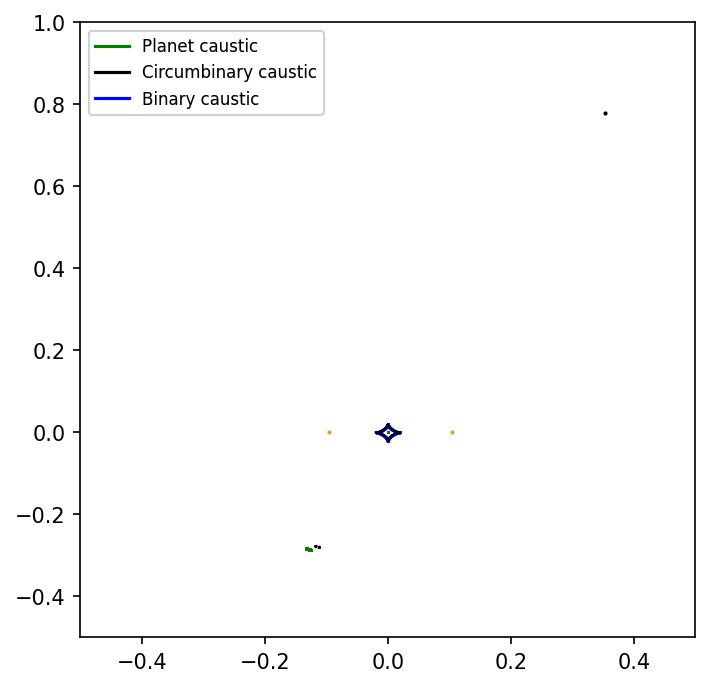

In [22]:
import matplotlib.lines as mlines
import VBMicrolensing

VBM = VBMicrolensing.VBMicrolensing()
VBM.Tol = 1e-4
VBM.SetMethod(VBM.Method.Multipoly)
parameters = [z1x,0,m1,            # First lens: x1_1, x1_2, m1
              z2x,0,m2,     # Second lens: x2_1, x2_2, m2
              z3x,z3y,m3      # Third lens: x3_1, x3_2, m3
                        ]    # Fourth lens: x4_1, x4_2, m4

VBM.SetLensGeometry(parameters) #Initialize the lens configuration

caustics = VBM.Multicaustics()


f = plt.figure(figsize=(5,5),dpi=150)
gs = gridspec.GridSpec(1,1)
ax = plt.subplot(gs[0])
plt.subplots_adjust(top = 0.9, bottom = 0.08, right = 0.95, left = 0.1, hspace = 0.1, wspace = 0.2)

plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 1)
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ratio = 1./1.
ax.set_aspect(abs((x_right - x_left) / (y_high - y_low))*ratio)

for i in range(2): #3
    ax.scatter(zlens[i*2], zlens[i*2+1], marker = "o",s = 1, color = "goldenrod")
ax.scatter(zlens[4], zlens[5], marker = "o",s = 1, color = "black")
#ax.plot(y1straj,y2straj,color = "k", linestyle = "--", label = "Source trajectory")
#ax.annotate('', xy=(y1straj[5100], y2straj[5100]), xytext=(y1straj[5090], y2straj[5090]),
#            arrowprops=dict(arrowstyle='->', color='black', lw=3))

planet_caustic = mm.Caustics(s=splanet, q=qplanet)
planetx, planety = planet_caustic.get_caustics()
planetx = np.array(planetx)
planety = np.array(planety)
planetxr = planetx*np.cos(planetorient) - planety*np.sin(planetorient)
planetyr = planetx*np.sin(planetorient) + planety*np.cos(planetorient)
ax.scatter(planetxr,planetyr, marker='.', s= 0.1,color='g', alpha=0.1)
for cau in caustics:
        plt.plot(cau[0], cau[1], 'k', alpha = 1.0, linewidth=1)

green_line = mlines.Line2D([], [], color='green', linestyle='-', label='Planet caustic')


binary_caustic = mm.Caustics(s=s2, q=q2)
binaryx, binaryy = binary_caustic.get_caustics()
ax.scatter(binaryx,binaryy, marker='.', s= 0.1,color='blue', alpha=0.3)
blue_line = mlines.Line2D([], [], color='blue', linestyle='-', label='Binary caustic')

black_line = mlines.Line2D([], [], color='black', linestyle='-', label='Circumbinary caustic')
handles, labels = ax.get_legend_handles_labels()
handles.append(green_line)
labels.append(green_line.get_label())
handles.append(black_line)
handles.append(blue_line)
labels.append(black_line.get_label())
labels.append(blue_line.get_label())
legend = ax.legend(handles, labels, loc="upper left", fontsize=8)
ax.add_artist(legend)



Magnification - VBMicrolensing 

In [ ]:
import VBMicrolensing

VBM = VBMicrolensing.VBMicrolensing()
VBM.Tol = 1e-4
VBM.SetMethod(VBM.Method.Multipoly)
parameters = [z1x,0,m1,            # First lens: x1_1, x1_2, m1
              z2x,0,m2,     # Second lens: x2_1, x2_2, m2
              z3x,z3y,m3      # Third lens: x3_1, x3_2, m3
                        ]    # Fourth lens: x4_1, x4_2, m4

VBM.SetLensGeometry(parameters) #Initialize the lens configuration



vbmag = []
for i in range(len(y1s)):
    vbmag.append(VBM.MultiMag(y1s[i], y2s[i],rs))
vbmag = np.array(vbmag)

planetmodel = mm.Model({'t_0': t0, 'u_0': u0planet, 't_E': tE, 'rho': rs, 's': splanet, 'q': qplanet, 'alpha': alphaplanet})
planetmodel.set_magnification_methods([t0 - gamma*tE, 'VBBL', t0 + gamma*tE])
planetmag = planetmodel.get_magnification(ts)
binmodel = mm.Model({'t_0': t0, 'u_0': u0, 't_E': tE, 'rho': rs, 's': s2, 'q': q2, 'alpha': alphamulens})
binmodel.set_magnification_methods([t0 - gamma*tE, 'VBBL', t0 + gamma*tE])
binmag = binmodel.get_magnification(ts)



In [109]:
len(y1straj)

10000

Position and sizes of planetary caustics

In [25]:
qpl = np.array([1e-3, 1e-4, 1e-5, 1e-6])
spl = np.array([0.6, 0.95, 1.1, 1.5])
phi = 135.0
qtr = 2*qpl
stri = 0.1*np.cos(phi) + np.sqrt(0.01*(np.cos(phi)**2 - 1) + spl**2)

def close_plan_caus(s, q):
    return 1./(1. + q)*(s - (1. - q)/s)
def far_plan_caus(s, q):
    return (s - 1./(s*(1. + q)))
def far_plan_caus_size(s, q):
    deltax = 4.*np.sqrt(q)/(s*np.sqrt(s**2 - 1.))
    deltay = 4.*np.sqrt(q)/(s*np.sqrt(s**2 + 1.))
    return (deltax, deltay)

for s in spl:
    print("s = %.2f"%s)
    for q in qpl:
        if s > 1.:
            print("q = %.1e: Caustic position= %.4f;  Caustic size= %s "%(q, far_plan_caus(s,q), far_plan_caus_size(s,q)))
        else:
            print("q = %.1e: Caustic position= %.4f "%(q, close_plan_caus(s,q)))
            
        

s = 0.60
q = 1.0e-03: Caustic position= -1.0639 
q = 1.0e-04: Caustic position= -1.0664 
q = 1.0e-05: Caustic position= -1.0666 
q = 1.0e-06: Caustic position= -1.0667 
s = 0.95
q = 1.0e-03: Caustic position= -0.1015 
q = 1.0e-04: Caustic position= -0.1025 
q = 1.0e-05: Caustic position= -0.1026 
q = 1.0e-06: Caustic position= -0.1026 
s = 1.10
q = 1.0e-03: Caustic position= 0.1918;  Caustic size= (0.2509329306699469, 0.07735193269300308) 
q = 1.0e-04: Caustic position= 0.1910;  Caustic size= (0.07935196008581538, 0.02446082887259318) 
q = 1.0e-05: Caustic position= 0.1909;  Caustic size= (0.025093293066994687, 0.007735193269300309) 
q = 1.0e-06: Caustic position= 0.1909;  Caustic size= (0.007935196008581537, 0.0024460828872593177) 
s = 1.50
q = 1.0e-03: Caustic position= 0.8340;  Caustic size= (0.07542472332656507, 0.04677642769637489) 
q = 1.0e-04: Caustic position= 0.8334;  Caustic size= (0.023851391759997755, 0.014792005232672779) 
q = 1.0e-05: Caustic position= 0.8333;  Caustic si

In [26]:
print(qtr,stri)

[2.e-03 2.e-04 2.e-05 2.e-06] [0.7  1.05 1.2  1.6 ]


In [281]:
stri = 0.1*np.cos(phi) + np.sqrt(0.01*(np.cos(phi)**2 - 1) + 1.0**2)
stri

1.1

Magnification - triplelens

In [19]:
mus = TRIL.TriLightCurve(mlens, zlens, y1s, y2s, rs, secnum, basenum, quaderr_Tol, relerr_Tol)

Light curves for CB - Triplelens and VBMicrolensing

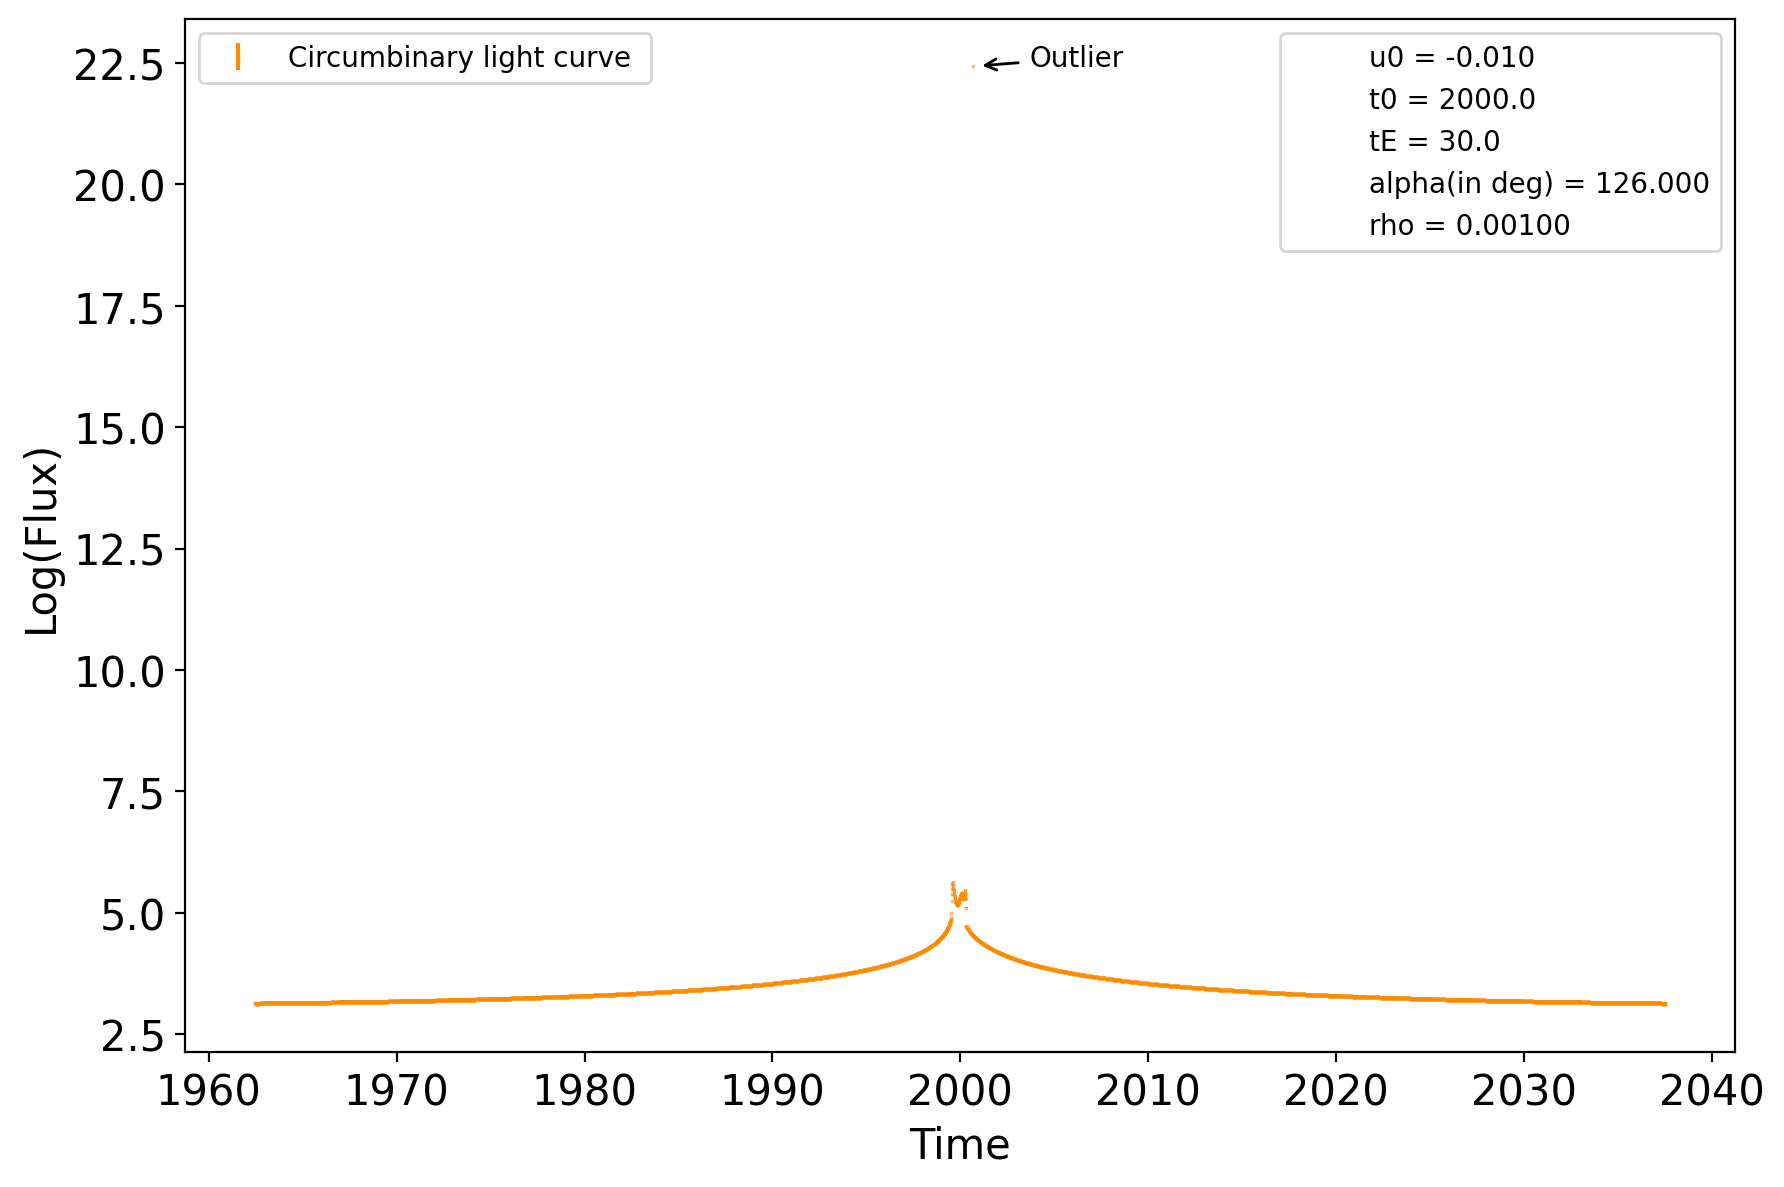

'\nfig, ax = plt.subplots(figsize = (15,10), dpi = 200)\nax.errorbar(ts, np.log10(cbflux_vbm), yerr = lcerrorbar_vbm/(cbflux_vbm*np.log(10)), fmt= \'.\', color=\'red\', markersize=0.5, label = "VB Microlensing")\nax.set_xlabel("Time")\nax.set_ylabel("Log(Flux)")\n\nhandles, labels = ax.get_legend_handles_labels()\nlegend1 = ax.legend(handles, labels, loc=\'lower center\')\nax.add_artist(legend1)\nplt.show()\n'

In [167]:
def magtoflux(mag, zeropint = 27.615):
    return 10.**(-0.4*(mag - zeropint))


photapert = 9
exp_time = 50
sourcemag = 20.0
blendmag = 27.615
sourceflux = magtoflux(sourcemag)
blendflux = magtoflux(blendmag)
rdnoise = 12.12*photapert
darkcurr = 1.072*exp_time*photapert
sky = 3.43*exp_time*photapert
#cbflux = sourceflux*np.array(mus) + blendflux
cbflux_vbm = sourceflux*np.array(vbmag) + blendflux
planetflux = sourceflux*np.array(planetmag) + blendflux
binflux = sourceflux*np.array(binmag) + blendflux
#lcerrorbar = np.sqrt(cbflux + darkcurr + sky + rdnoise**2)
lcerrorbar_vbm = np.sqrt(cbflux_vbm + darkcurr + sky + rdnoise**2)
fig, ax = plt.subplots(figsize = (10,7), dpi = 200)
#ax.errorbar(ts, np.log10(cbflux), yerr = lcerrorbar/(cbflux*np.log(10)), fmt= '.', color='darkorange', markersize=0.5, label = "TripleLens")
ax.errorbar(ts, np.log10(cbflux_vbm), yerr = lcerrorbar_vbm/(cbflux_vbm*np.log(10)), fmt= '.', color='darkorange', markersize=0.5, label = "Circumbinary light curve ")
#label the point with the maximum magnification
maxmag = np.max(cbflux_vbm)
maxmagindex = np.where(cbflux_vbm == maxmag)[0][0]
ax.annotate('Outlier', xy=(ts[maxmagindex]+0.2, np.log10(maxmag)), xytext=(ts[maxmagindex]+3, np.log10(maxmag)),
            arrowprops=dict(arrowstyle='->', color='black', lw=1))
#ax.plot(ts, np.log10(planetflux), color='red', label = "Planet model")
#ax.plot(ts, np.log10(binflux), color='blue', label = "Binary model")
#ax.plot(ts, np.log10(cbflux), color='darkorange', label = "TripleLens")
ax.set_xlabel("Time", fontsize = 15)
ax.set_ylabel("Log(Flux)", fontsize = 15)
ax.tick_params(axis='both', labelsize=15)  # 'both' applies to x and y ticks
handles, labels = ax.get_legend_handles_labels()
legend1 = ax.legend(handles, labels, loc='upper left')

values_legend = ax.legend(
    handles=[mlines.Line2D([], [], color='none', label="u0 = %.3f"%u0),
             mlines.Line2D([], [], color='none', label="t0 = %.1f"%t0),
             mlines.Line2D([], [], color='none', label="tE = %.1f"%tE),
             mlines.Line2D([], [], color='none', label="alpha(in deg) = %.3f"%(alpha*180./np.pi)),
             mlines.Line2D([], [], color='none', label="rho = %.5f"%rs)],
    loc='upper right', bbox_to_anchor=(1, 1)
)
ax.add_artist(legend1)
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ratio = 1./1.5
ax.set_aspect(abs((x_right - x_left) / (y_high - y_low))*ratio)
#plt.xlim(200, 2009)
#plt.ylim(3.6, 3.8)

plt.show()
"""
fig, ax = plt.subplots(figsize = (15,10), dpi = 200)
ax.errorbar(ts, np.log10(cbflux_vbm), yerr = lcerrorbar_vbm/(cbflux_vbm*np.log(10)), fmt= '.', color='red', markersize=0.5, label = "VB Microlensing")
ax.set_xlabel("Time")
ax.set_ylabel("Log(Flux)")

handles, labels = ax.get_legend_handles_labels()
legend1 = ax.legend(handles, labels, loc='lower center')
ax.add_artist(legend1)
plt.show()
"""


In [168]:
print(parameters)

[-0.09610389610389611, 0, 0.5194805194805194, 0.1038961038961039, 0, 0.4805194805194805, 0.35389610389610404, 0.7794228634059948, 5.194805194805194e-06]


In [73]:
A = vbmag[3575]
ts[3575], A


(1999.7447562161412, 2.3195829693837657)

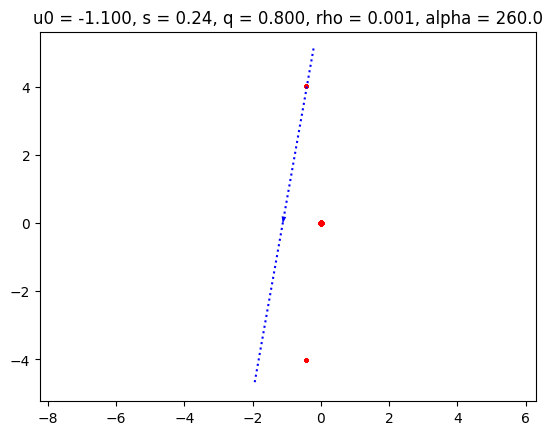

In [59]:
#Caustics for binary lens
plt.figure()
binary.plot_trajectory(t_range=[t0 - 5.0*tE, t0 + 5.0*tE], color='blue', linestyle=':',
                       caustics=True, arrow=True)
plt.axis('equal')
#zoom into (-2,0)


plt.title('u0 = %.3f, s = %0.2f, q = %0.3f, rho = %0.3f, alpha = %0.1f'%(u0,s2,q2,rs, alphamulens))

plt.show()

In [33]:
traj = binary.get_trajectory(tn)
traj.get_xy()
traj.y




array([200.5       , 200.49989999, 200.49979998, ..., 199.50020002,
       199.50010001, 199.5       ])

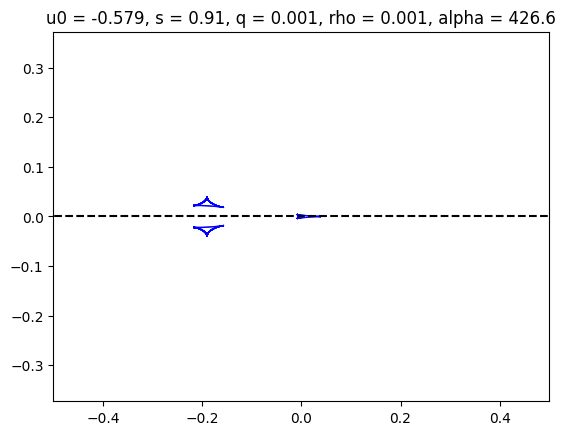

In [8]:
#caustics for planetary system
plt.figure()
planet_caustic.plot(s = 1, color='blue', linestyle='--')
plt.axis('equal')
#zoom into (-2,0)
#plot y =0 line
plt.plot([-1.,1.],[0.,0.],color = "k", linestyle = "--")

plt.xlim(-0.5,0.5)
plt.ylim(-0.25,0.25)

plt.title('u0 = %.3f, s = %0.2f, q = %0.3f, rho = %0.3f, alpha = %0.1f'%(u0planet,splanet,qplanet,rs, alphaplanet))

plt.show()

In [50]:
traj = planet.get_trajectory(tn)
traj.get_xy()
traj.y

array([-178.3868569 , -178.38676817, -178.38667944, ..., -177.49985427,
       -177.49976554, -177.49967681])

### light curve calculation

generating light curve ...


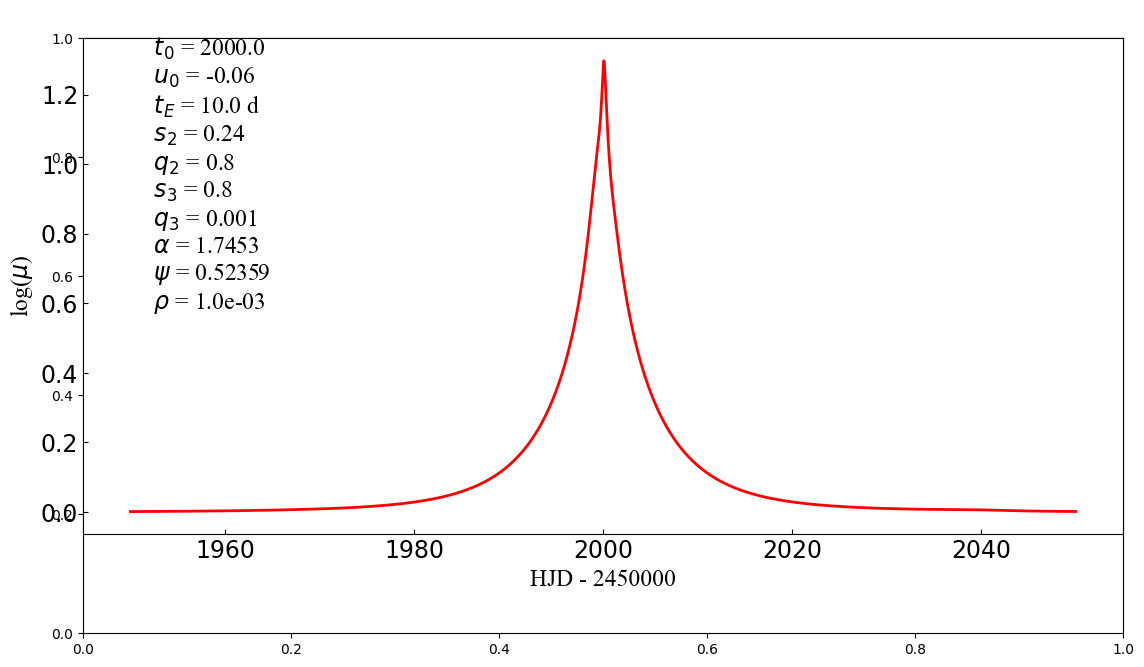

In [10]:


# computing light curve
print("generating light curve ...")
# for small source radius like here, we can actuarlly use quaderr_Tol = 1e-1 or larger 
mus = TRIL.TriLightCurve(mlens, zlens, y1s, y2s, rs, secnum, basenum, quaderr_Tol, relerr_Tol)
main, gs = pltlkv(ts, mus, params, label = "Without limb-darkening")
plt.show()

In [12]:
print(mus[5000])

18.96171835485654


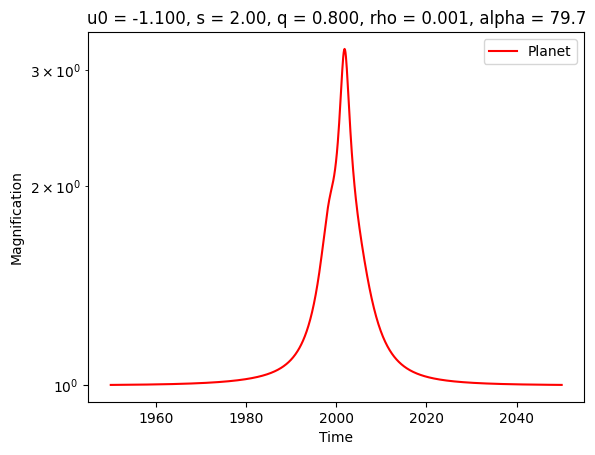

In [5]:
#plot light curve for binary lens
import matplotlib.pyplot as plt
plt.figure()
binary.plot_magnification(t_range=(t0-5.*tE, t0+5.*tE), 
    color='red', linestyle='-', zorder=1, label='Planet')
plt.title('u0 = %.3f, s = %0.2f, q = %0.3f, rho = %0.3f, alpha = %0.1f'%(u0,s2,q2,rs, alphamulens))
plt.yscale('log')
plt.legend(loc='best')

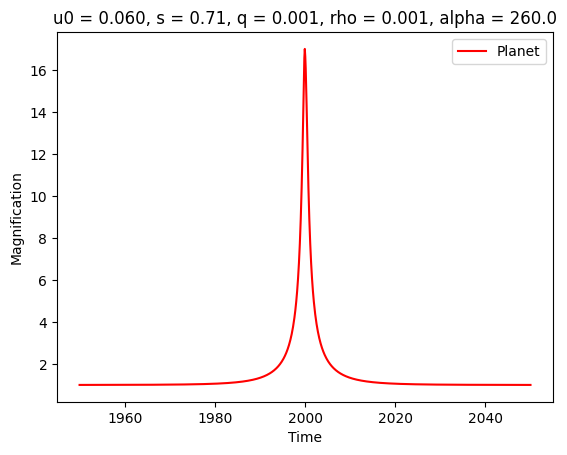

In [13]:
#plot light curve for planetary system
plt.figure()
planet.plot_magnification(t_range=(t0-5.*tE, t0+5.*tE), 
    color='red', linestyle='-', zorder=1, label='Planet')
plt.title('u0 = %.3f, s = %0.2f, q = %0.3f, rho = %0.3f, alpha = %0.1f'%(u0,splanet,qplanet,rs, alphamulens))
plt.legend(loc='best')

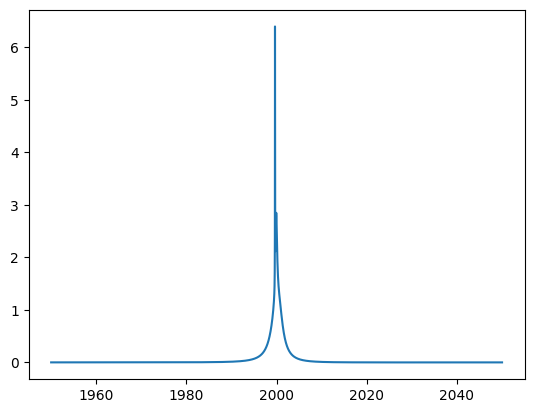

In [31]:
diffmag = (mus - binarymag)/planetmag
plt.figure()
plt.plot(ts, diffmag)
plt.show()

### with limb darkening

In [16]:
Gamma = 0.51 # Gamma coefficient of the linear limb-darkening profile
u = 3. * Gamma / (2. + Gamma) # gamma_to_u(Gamma)
# parameters controls the accuracy of limb-darkening calculation
RelTolLimb, AbsTolLimb = 1e-2, 1e-2

# source position
ts = np.linspace(7480, 7500, 100)
tn = (ts - t0) / tE;
y1s = u0 * salpha + tn * calpha;
y2s = u0 * calpha - tn * salpha;
rs = 0.005 # use a larger source radius to see the limb-darkening effect
params[9] = rs

In [17]:
print("generating light curve ...")
mus = TRIL.TriLightCurve(mlens, zlens, y1s, y2s, rs, secnum, basenum, quaderr_Tol, relerr_Tol)

generating light curve ...


In [18]:
print("generating light curve with limb-darkening ...")
musLimb = TRIL.TriLightCurveLimb(mlens, zlens, y1s, y2s, rs, secnum, basenum, quaderr_Tol, relerr_Tol, RelTolLimb, AbsTolLimb, u)
#np.savez("../doc/demolkvs", ts=np.array(ts), muslimb=np.array(musLimb), musnolimb = np.array(mus))

generating light curve with limb-darkening ...


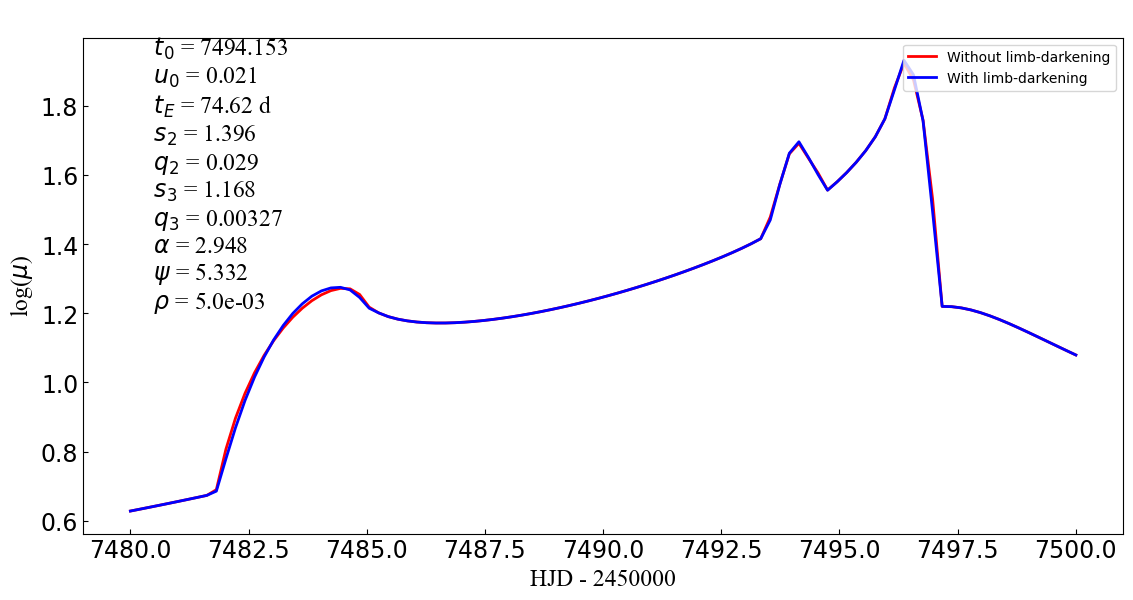

In [19]:
main, gs = pltlkv(ts, mus, params, label = "Without limb-darkening")
main.plot(ts, np.log10( musLimb ), color="b",linewidth = 2, label = "With limb-darkening")
plt.legend(loc = "upper right")
plt.show()

In [27]:
np.arctan2(3,2)*180./np.pi

56.309932474020215

### Fitting Trials

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import MulensModel as mm
import scipy.optimize as op
import os
import astropy.units as u
from lmfit import create_params, minimize
from lmfit.printfuncs import report_fit

def magtoflux(mag, zeropint = 27.615):
    return 10.**(-0.4*(mag - zeropint))

def chi2_for_model(theta, event, parameters_to_fit, data_ref):
    """
    for given event set attributes from parameters_to_fit
    (list of str) to values from the theta list
    """
    for (index, key) in enumerate(parameters_to_fit):
        if (key == 't_E' or key =='rho') and theta[index] < 0.:
            return np.inf
        setattr(event.model.parameters, key, theta[index])
    return event.get_chi2_for_dataset(data_ref)

def fit_model(event, parameters_to_fit, bounds = None, data_ref = 0):
    """
    Fit an "event" with "parameters_to_fit" as free parameters.
    
    event = a MulensModel event
    parameters_to_fit = list of parameters to fit
    """
    # Take the initial starting point from the event.
    x0 = []
    for key in parameters_to_fit:
        value = getattr(event.model.parameters, key)
        if isinstance(value, u.Quantity):
            x0.append(value.value)
        else:
            x0.append(value)

    # *Execute fit using a 'Nelder-Mead' algorithm*
    result = op.minimize(
       chi2_for_model, x0, args=(event, parameters_to_fit, data_ref), bounds=bounds,
       method='Nelder-Mead', options={'xatol': 1e-15, 'fatol': 1e-15, 'adaptive': True, 'maxfev' : 5000})
    #result = op.minimize(chi2_for_model, x0, args=(event, parameters_to_fit, data_ref), method= 'L-BFGS-B' , options={'ftol': 1e-14, 'gtol': 1e-14, 'maxfun': 2000}, bounds=bounds)
    return result


def find_residuals(params, event, parameters_to_fit):
    for (index, key) in enumerate(parameters_to_fit):
        setattr(event.model.parameters, key, params[key].value)
    event.fit_fluxes()
    srcflux, bldflux = event.get_ref_fluxes()
    modelmag = event.model.get_lc(event.datasets[0].time, source_flux=srcflux, blend_flux=bldflux)
    modelflux = mm.Utils.get_flux_from_mag(modelmag)
    residuals = (event.datasets[0].flux - modelflux) / event.datasets[0].err_flux
    return residuals  

def fit_model_lm(event, parameters_to_fit, bounds = None):
    """
    Fit an "event" with "parameters_to_fit" as free parameters.
    
    event = a MulensModel event
    parameters_to_fit = list of parameters to fit
    """
    # Take the initial starting point from the event.
    x0 = []
    for key in parameters_to_fit:
        value = getattr(event.model.parameters, key)
        if isinstance(value, u.Quantity):
            x0.append(value.value)
        else:
            x0.append(value)
   
    fit_params = create_params(t_0 = dict(value=x0[0], max=bounds[0][1], min=bounds[0][0]),
                               u_0 = dict(value=x0[1], max=bounds[1][1], min=bounds[1][0]),
                               t_E = dict(value=x0[2], max=bounds[2][1], min=bounds[2][0]),
                               rho = dict(value=x0[3], max=bounds[3][1], min=bounds[3][0]),
                               s = dict(value=x0[4], max=bounds[4][1], min=bounds[4][0]),
                               q = dict(value=x0[5], max=bounds[5][1], min=bounds[5][0]),
                               alpha = dict(value=x0[6], max=bounds[6][1], min=bounds[6][0]))
    result = minimize(find_residuals, fit_params, args=(event, parameters_to_fit), max_nfev = 7500, ftol = 1e-20, gtol = 1e-20)
    return result
    
    


Load Files

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import MulensModel as mm
import scipy.optimize as op
import os
import astropy.units as u

falpha = 54.0
alpha = 360.0 - falpha
fu0 = -0.01
file_name = "../Multiple_lc_run2-Me/s20p2s30p9psi60.0alpha%.1f/u%.3falpha%d"%(falpha,fu0,alpha)

#Read CB data
hjd, cbflux, cbflux_err = np.loadtxt(file_name+"_flux.txt", usecols=[0,1,2], unpack=True)
my_data = mm.MulensData([hjd, cbflux, cbflux_err], phot_fmt="flux", chi2_fmt="flux")
print("{:} file was imported".format(file_name))
true_params = np.loadtxt(file_name+"_info.txt", skiprows=1)
params_cb = {"t_0": true_params[0], "u_0": true_params[1], "t_E": true_params[2], "s2": true_params[3], "q2": true_params[4], "alpha": true_params[5], "rho": true_params[6], "s3": true_params[7], "q3": true_params[8], "psi": true_params[9]}

#Read binary data
hjd, binaryflux, binaryflux_err = np.loadtxt(file_name+"_binflux.txt", usecols=[0,1,2], unpack=True)
my_data_bin = mm.MulensData([hjd, binaryflux, binaryflux_err], phot_fmt="flux", chi2_fmt="flux")
true_params = np.loadtxt(file_name+"_bininfo.txt", skiprows=1)
params_bin = {"t_0": true_params[0], "u_0": true_params[1], "t_E": true_params[2], "s": true_params[3], "q": true_params[4], "alpha": true_params[5], "rho": true_params[6]}

#Read planet data
hjd, planetflux, planetflux_err = np.loadtxt(file_name+"_planetflux.txt", usecols=[0,1,2], unpack=True)
my_data_planet = mm.MulensData([hjd, planetflux, planetflux_err], phot_fmt="flux", chi2_fmt="flux")
true_params = np.loadtxt(file_name+"_planetinfo.txt", skiprows=1)
params_planet = {"t_0": true_params[0], "u_0": true_params[1], "t_E": true_params[2], "s": true_params[3], "q": true_params[4], "alpha": true_params[5], "rho": true_params[6]}

true_chisq = len(cbflux) - len(params_bin)



../Multiple_lc_run2-Me/s20p2s30p9psi60.0alpha54.0/u-0.010alpha306 file was imported


Fit PSPL Model and find delta chi square

Fit initial model

In [6]:
import scipy.optimize as op
from scipy.optimize import Bounds

t_0 = params_bin['t_0']
u_0 = params_bin['u_0']
t_E = params_bin['t_E']
rho = params_bin['rho']
sbin = params_bin['s']
qbin = params_bin['q']
alphabin = params_bin['alpha']
splanet = params_planet['s']
qplanet = params_planet['q']
alphaplanet = params_planet['alpha']
u0planet = params_planet['u_0']
gamma = 1.25

pspl_model = mm.Model({'t_0': t_0, 'u_0': u_0, 't_E': t_E, 'rho': rho})
pspl_model.set_magnification_methods([t_0 - gamma*t_E, 'finite_source_uniform_Gould94', t_0 + gamma*t_E])
planet_model = mm.Model({'t_0': t_0, 'u_0': u0planet, 't_E': t_E, 's': splanet, 'q': qplanet, 'alpha': alphaplanet, 'rho': rho})
planet_model.set_magnification_methods([t_0 - gamma*t_E, 'VBBL', t_0 + gamma*t_E])
binary_model = mm.Model({'t_0': t_0, 'u_0': u_0, 't_E': t_E, 's': sbin, 'q': qbin, 'alpha': alphabin, 'rho': rho})
binary_model.set_magnification_methods([t_0 - gamma*t_E, 'VBBL', t_0 + gamma*t_E])

my_event = mm.Event(datasets=[my_data], model=pspl_model)
init_fit = mm.FitData(dataset=my_data, model=pspl_model)
init_fit.fit_fluxes()
sourceflux = init_fit.source_flux
blendflux = init_fit.blend_flux
psplmaginit = pspl_model.get_lc(my_data.time, source_flux=sourceflux, blend_flux=blendflux)
psplfluxinit = mm.Utils.get_flux_from_mag(psplmaginit)
print("delta chi-square = ", my_event.get_chi2_for_dataset(0)- true_chisq)



parameters_to_fit = ["t_0", "u_0", "t_E", "rho"]
bounds = ((0.,10000), (-10.0, 10.0), (0., 100.), (0.0, 1.0)) 
result = fit_model(my_event, parameters_to_fit, bounds)
print("Fitting was successful? {:}".format(result.success))
if not result.success:
    print(result.message)
print("Function evaluations: {:}".format(result.nfev))
if isinstance(result.fun, np.ndarray):
    if result.fun.ndim == 0:
        result_fun = float(result.fun)
    else:
        result_fun = result.fun[0]
else:
    result_fun = result.fun
print("The smallest function value: {:.3f}".format(result_fun))
print("for parameters: {:.5f} {:.4f} {:.3f} {:.3f}".format(*result.x.tolist()))
sourceflux = my_event.get_flux_for_dataset(0)[0]
blendflux = my_event.get_flux_for_dataset(0)[1]
print("Magnitude: %.5f %.5f"%(mm.Utils.get_mag_from_flux(sourceflux),mm.Utils.get_mag_from_flux(blendflux)))
print("delta chi-square = ", my_event.get_chi2_for_dataset(0)- true_chisq)

sourceflux, blendflux = my_event.get_ref_fluxes()
psplmagfin = my_event.model.get_lc(my_data.time, source_flux=sourceflux, blend_flux=blendflux)
psplfluxfin = mm.Utils.get_flux_from_mag(psplmagfin)





delta chi-square =  209482.74414782762
Fitting was successful? False
Maximum number of function evaluations has been exceeded.
Function evaluations: 5000
The smallest function value: 214955.397
for parameters: 2000.15585 -0.0725 40.344 0.000
Magnitude: 14.76923 16.21927
delta chi-square =  207762.39699328874


/var/folders/hn/6p7kgmw55kn4chlmx3c4v4pw0000gp/T/ipykernel_87605/115970039.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Magnitude: %.5f %.5f"%(mm.Utils.get_mag_from_flux(sourceflux),mm.Utils.get_mag_from_flux(blendflux)))


In [154]:
#Fit a planet model
my_event.model = planet_model
init_fit = mm.FitData(dataset=my_data, model=planet_model)
init_fit.fit_fluxes()
sourceflux = init_fit.source_flux
blendflux = init_fit.blend_flux
planetmaginit = planet_model.get_lc(my_data.time, source_flux=sourceflux, blend_flux=blendflux)
planetfluxinit = mm.Utils.get_flux_from_mag(planetmaginit)
print("delta chi-square = ", my_event.get_chi2_for_dataset(0)- true_chisq)

parameters_to_fit = ["t_0", "u_0", "t_E", "rho", "s", "q", "alpha"]
bounds = ((0.,10000), (-10.0, 10.0), (0., 100.), (0.0, 1.0), (0.0, 100.0),(0.0, 1.0), (0., 360.)) 
result = fit_model(my_event, parameters_to_fit, bounds)
print("Fitting was successful? {:}".format(result.success))
if not result.success:
    print(result.message)
print("Function evaluations: {:}".format(result.nfev))
if isinstance(result.fun, np.ndarray):
    if result.fun.ndim == 0:
        result_fun = float(result.fun)
    else:
        result_fun = result.fun[0]
else:
    result_fun = result.fun
print("The smallest function value: {:.3f}".format(result_fun))
print("for parameters: {:.5f} {:.4f} {:.3f} {:.3f} {:.3f} {:.4f} {:.2f}".format(*result.x.tolist()))
sourceflux = my_event.get_flux_for_dataset(0)[0]
blendflux = my_event.get_flux_for_dataset(0)[1]
print("Magnitude: %.5f %.5f"%(mm.Utils.get_mag_from_flux(sourceflux),mm.Utils.get_mag_from_flux(blendflux)))
print("delta chi-square = ", my_event.get_chi2_for_dataset(0)- true_chisq)

sourceflux, blendflux = my_event.get_ref_fluxes()
planetmagfin = my_event.model.get_lc(my_data.time, source_flux=sourceflux, blend_flux=blendflux)
planetfluxfin = mm.Utils.get_flux_from_mag(planetmagfin)
params_planetfinal = {"t_0": result.x[0], "u_0": result.x[1], "t_E": result.x[2], "rho": result.x[3], "s": result.x[4], "q": result.x[5], "alpha": result.x[6]}



delta chi-square =  377858.0100617357
Fitting was successful? False
Maximum number of function evaluations has been exceeded.
Function evaluations: 5000
The smallest function value: 11969.131
for parameters: 1999.98260 -0.1024 27.694 0.001 0.958 0.0006 291.29
Magnitude: 14.32560 nan


/Users/murlidhar.4/Documents/Projects/microlens/.venv/lib/python3.9/site-packages/MulensModel/utils.py:114: UserWarning: Flux to magnitude conversion approached negative flux
  warnings.warn(
/Users/murlidhar.4/Documents/Projects/microlens/.venv/lib/python3.9/site-packages/MulensModel/utils.py:117: RuntimeWarning: invalid value encountered in log10
  mag = zeropoint - 2.5 * np.log10(flux)
/var/folders/hn/6p7kgmw55kn4chlmx3c4v4pw0000gp/T/ipykernel_60327/3845157310.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Magnitude: %.5f %.5f"%(mm.Utils.get_mag_from_flux(sourceflux),mm.Utils.get_mag_from_flux(blendflux)))


delta chi-square =  4776.131287161608


In [4]:
#Fit a binary model
my_event.model = binary_model
init_fit = mm.FitData(dataset=my_data, model=binary_model)
init_fit.fit_fluxes()
sourceflux = init_fit.source_flux
blendflux = init_fit.blend_flux
binmaginit = binary_model.get_lc(my_data.time, source_flux=sourceflux, blend_flux=blendflux)
binfluxinit = mm.Utils.get_flux_from_mag(binmaginit)
print("delta chi-square = ", my_event.get_chi2_for_dataset(0)- true_chisq)

parameters_to_fit = ["t_0", "u_0", "t_E", "rho", "s", "q", "alpha"]
bounds = ((0.,10000), (-10.0, 10.0), (0., 100.), (0.0, 1.0), (0.0, 100.0),(0.0, 1.0), (0., 360.)) 
result = fit_model(my_event, parameters_to_fit, bounds)
print("Fitting was successful? {:}".format(result.success))
if not result.success:
    print(result.message)
print("Function evaluations: {:}".format(result.nfev))
if isinstance(result.fun, np.ndarray):
    if result.fun.ndim == 0:
        result_fun = float(result.fun)
    else:
        result_fun = result.fun[0]
else:
    result_fun = result.fun
print("The smallest function value: {:.3f}".format(result_fun))
print("for parameters: {:.5f} {:.4f} {:.3f} {:.3f} {:.3f} {:.4f} {:.2f}".format(*result.x.tolist()))
sourceflux = my_event.get_flux_for_dataset(0)[0]
blendflux = my_event.get_flux_for_dataset(0)[1]
print("Magnitude: %.5f %.5f"%(mm.Utils.get_mag_from_flux(sourceflux),mm.Utils.get_mag_from_flux(blendflux)))
print("delta chi-square = ", my_event.get_chi2_for_dataset(0)- true_chisq)

sourceflux, blendflux = my_event.get_ref_fluxes()
binmagfin = my_event.model.get_lc(my_data.time, source_flux=sourceflux, blend_flux=blendflux)
binfluxfin = mm.Utils.get_flux_from_mag(binmagfin)
params_binfinal = {"t_0": result.x[0], "u_0": result.x[1], "t_E": result.x[2], "rho": result.x[3], "s": result.x[4], "q": result.x[5], "alpha": result.x[6]}


delta chi-square =  2894.909190154831


: 

: 

In [146]:
# Fit binary light curve with binary model

sgns = np.random.choice([-1,1], size = 7)
#planet2_model = mm.Model({'t_0': t_0, 'u_0': u0planet, 't_E': t_E, 's': splanet, 'q': qplanet, 'alpha': alphaplanet, 'rho': rho})
planet2_model = mm.Model({'t_0': t_0 + sgns[0]*0.25, 'u_0': u0planet + sgns[1]*0.025*u0planet, 't_E': t_E + sgns[2]*0.025*t_E, 's': splanet + sgns[3]*0.025*splanet, 'q': qplanet + sgns[4]*0.025*qplanet, 'alpha': alphaplanet + sgns[5]*0.5, 'rho': rho + sgns[6]*0.025*rho})
planet2_model.set_magnification_methods([t_0 - gamma*t_E, 'VBBL', t_0 + gamma*t_E])
binary2_model = mm.Model({'t_0': t_0, 'u_0': u_0, 't_E': t_E, 's': sbin, 'q': qbin, 'alpha': alphabin, 'rho': rho})
binary2_model.set_magnification_methods([t_0 - gamma*t_E, 'VBBL', t_0 + gamma*t_E])
params_planetinit = planet2_model.parameters.parameters
print(params_planetinit)
my_event_planet = mm.Event(datasets=[my_data_planet], model=planet2_model)
print("delta chi-square = ", my_event_planet.get_chi2_for_dataset(0)- true_chisq)

parameters_to_fit = ["t_0", "u_0", "t_E", "rho", "s", "q", "alpha"]
bounds = ((0.,10000), (-10.0, 10.0), (0., 100.), (0.0, 1.0), (0.0, 100.0),(0.0, 1.0), (0.0, 360.)) 
result = fit_model(my_event_planet, parameters_to_fit, bounds)

print("Fitting was successful? {:}".format(result.success))
if not result.success:
    print(result.message)
print("Function evaluations: {:}".format(result.nfev))
if isinstance(result.fun, np.ndarray):
    if result.fun.ndim == 0:
        result_fun = float(result.fun)
    else:
        result_fun = result.fun[0]
else:
    result_fun = result.fun

print("The smallest function value: {:.3f}".format(result_fun))#result.chisqr
print("for parameters: , {:.5f} {:.4f} {:.3f} {:.3f} {:.3f} {:.4f} {:.2f}".format(*result.x.tolist()))#result.params)#
print("delta chi-square = ", my_event_planet.get_chi2_for_dataset(0)- true_chisq)

params_planetfinal = {"t_0": result.x[0], "u_0": result.x[1], "t_E": result.x[2], "rho": result.x[3], "s": result.x[4], "q": result.x[5], "alpha": result.x[6]} #{"t_0": result.params['t_0'].value, "u_0": result.params['u_0'].value, "t_E": result.params['t_E'].value, "rho": result.params['rho'].value, "s": result.params['s'].value, "q": result.params['q'].value, "alpha": result.params['alpha'].value }  #


{'t_0': 1999.75, 'u_0': -0.1029354974653049, 't_E': <Quantity 29.25 d>, 's': 0.9813015257509784, 'q': 0.0005540540540540541, 'alpha': 234.73181320967728, 'rho': 0.001025}
delta chi-square =  93010.68611303941
Fitting was successful? False
Maximum number of function evaluations has been exceeded.
Function evaluations: 5000
The smallest function value: 7271.382
for parameters: , 1999.99994 -0.1007 29.965 0.001 0.957 0.0005 235.27
delta chi-square =  78.38177369746245


In [129]:
params_planetfinal = {"t_0": result.params['t_0'].value, "u_0": result.params['u_0'].value, "t_E": result.params['t_E'].value, "rho": result.params['rho'].value, "s": result.params['s'].value, "q": result.params['q'].value, "alpha": result.params['alpha'].value }
params_planetfinal

{'t_0': 1999.9221418584812,
 'u_0': -0.13185918078940517,
 't_E': 22.55366414177699,
 'rho': 0.001850266150410007,
 's': 0.8981719111449515,
 'q': 0.0007716104067935214,
 'alpha': 234.61754910324768}

In [148]:
params_planetinit = {'t_0': t_0 + sgns[0]*0.25, 'u_0': u0planet + sgns[1]*0.025*u0planet, 't_E': t_E + sgns[2]*0.025*t_E, 's': splanet + sgns[3]*0.025*splanet, 'q': qplanet + sgns[4]*0.025*qplanet, 'alpha': alphaplanet + sgns[5]*0.5, 'rho': rho + sgns[6]*0.025*rho}


Plot initial and Final Models

In [2]:
import matplotlib.lines as mlines
import numpy as np
import matplotlib.pyplot as plt
import MulensModel as mm
import scipy.optimize as op
import os
import astropy.units as u

def plot_init_final(init_params, final_params, my_data, data_params, chisq, binplan, alpha):
    fig, ax = plt.subplots(figsize = (15,10), dpi = 200) 
    true_chisq = len(my_data.flux) - len(init_params)
    #Plot Data
    if len(data_params) == 7:
        dat = ax.errorbar(my_data.time, np.log10(my_data.flux), yerr=my_data.err_flux/(my_data.flux*np.log(10)), fmt= '.', color='darkorange', markersize=0.5, label = r'Data : $t_0$=%.1f,$u_0$=%.3f,$t_E$=%.1f,$s$=%0.2f,$q$=%0.3f,$\alpha$=%0.1f,$\rho$=%0.3f'%(data_params["t_0"],data_params["u_0"],data_params["t_E"],data_params["s"],data_params["q"],data_params["alpha"],data_params["rho"]))
        ax.set_xlabel('HJD')
        ax.set_ylabel('log(Flux)')
        ax.set_title('u0 = %.3f, alpha = %.1f, %s'%(data_params["u_0"], alpha, binplan))
        plt.legend(loc='best')
    elif len(data_params) > 7:
        dat = ax.errorbar(my_data.time, np.log10(my_data.flux), yerr=my_data.err_flux/(my_data.flux*np.log(10)), fmt= '.', color='darkorange', markersize=0.5, label = r'Data : $t_0$=%.1f,$u_0$=%.3f,$t_E$=%.1f,$s_2$=%0.2f,$q_2$=%0.3f,$\alpha$=%0.1f,$\rho$=%0.3f, $s_3$ = %0.2f, $q_3$ = %0.3f, $\psi$=%0.1f'%(data_params["t_0"],data_params["u_0"],data_params["t_E"],data_params["s2"],data_params["q2"],data_params["alpha"],data_params["rho"], data_params["s3"], data_params["q3"], data_params["psi"]))
        ax.set_xlabel('HJD')
        ax.set_ylabel('log(Flux)')
        ax.set_title('u0 = %.3f, alpha = %.1f'%(data_params["u_0"], alpha))
        plt.legend(loc='best')
   
    #Define Models 
    init_model = mm.Model({'t_0': init_params["t_0"], 'u_0': init_params["u_0"], 't_E': init_params["t_E"], 's': init_params["s"], 'q': init_params["q"], 'alpha': init_params["alpha"], 'rho': init_params["rho"]})
    fin_model = mm.Model({'t_0': final_params["t_0"], 'u_0': final_params["u_0"], 't_E': final_params["t_E"], 's': final_params["s"], 'q': final_params["q"], 'alpha': final_params["alpha"], 'rho': final_params["rho"]})
    init_model.set_magnification_methods([init_params["t_0"] - 1.25*init_params["t_E"], 'VBBL', init_params["t_0"] + 1.25*init_params["t_E"]])   
    fin_model.set_magnification_methods([final_params["t_0"] - 1.25*final_params["t_E"], 'VBBL', final_params["t_0"] + 1.25*final_params["t_E"]])
    my_event = mm.Event(datasets=[my_data], model=fin_model)
    #Find fluxes and calculate light curves
    init_fit = mm.FitData(dataset=my_data, model=init_model)
    init_fit.fit_fluxes()
    initsourceflux = init_fit.source_flux #init_params["sf"]#
    initblendflux = init_fit.blend_flux #init_params["bf"]#
    print(initsourceflux, initblendflux)
    initlcmag = init_model.get_lc(my_data.time, source_flux=initsourceflux, blend_flux=initblendflux)
    initlcflux = mm.Utils.get_flux_from_mag(initlcmag)

    fin_fit = mm.FitData(dataset=my_data, model=my_event.model)
    fin_fit.fit_fluxes()
    finsourceflux = fin_fit.source_flux #final_params["sf"]#
    finblendflux = fin_fit.blend_flux #final_params["bf"]#
    print(finsourceflux, finblendflux)
    finlcmag = fin_model.get_lc(my_data.time, source_flux=finsourceflux, blend_flux=finblendflux)
    finlcflux = mm.Utils.get_flux_from_mag(finlcmag)
    deltax2 = my_event.get_chi2_for_dataset(0)- true_chisq
    print("delta chi-square = ", deltax2, my_event.get_chi2_for_dataset(0), true_chisq)
    #Plot Models                                         
    #ax.plot(my_data.time, np.log10(initlcflux), color='red', linestyle='--', markersize=0.5, label = r'Initial Model: $t_0$=%.1f,$u_0$=%.3f,$t_E$=%.1f,$\rho$=%0.3f,$s$=%0.2f,$q$=%0.4f,$\alpha$=%0.1f'%(init_params["t_0"],init_params["u_0"],init_params["t_E"],init_params["rho"],init_params["s"],init_params["q"],init_params["alpha"]))
    mod = ax.plot(my_data.time, np.log10(finlcflux), color='blue', linestyle='-', markersize=0.5, label= r'Final Model: $t_0$=%.1f,$u_0$=%.3f,$t_E$=%.1f,$\rho$=%0.3f,$s$=%0.2f,$q$=%0.4f,$\alpha$=%0.1f'%(final_params["t_0"],final_params["u_0"],final_params["t_E"],final_params["rho"],final_params["s"],final_params["q"],final_params["alpha"]))
    blue_line = mlines.Line2D([], [], color='blue', label='Delta Chi2 = %.1f'%(chisq))
    handles, labels = ax.get_legend_handles_labels()
    legend1 = ax.legend(handles, labels, loc='lower center')
    ax.add_artist(legend1)
    legend2 = ax.legend(handles = [blue_line], loc='upper left')
    ax.add_artist(legend2)

    # inset axes....
    x1, x2, y1, y2 = 1993, 2007, np.log10(np.max(my_data.flux)) - 0.8, np.log10(np.max(my_data.flux))  # subregion of the original image
    axins = ax.inset_axes(
        [0.64,0.64,0.35,0.33],
        xlim=(x1, x2), ylim=(y1, y2), xticks=[])
    axins.errorbar(my_data.time, np.log10(my_data.flux), yerr=my_data.err_flux/(my_data.flux*np.log(10)), fmt= '.', color='darkorange', markersize=0.5)
    #axins.plot(my_data.time, np.log10(initlcflux), color='red', linestyle='--', markersize=0.5)
    axins.plot(my_data.time, np.log10(finlcflux), color='blue', linestyle='-', markersize=0.5)
    #ax.indicate_inset_zoom(axins, edgecolor="black")

    #find residuals
    residuals = (my_data.flux - finlcflux)/my_data.flux
    axins2 = ax.inset_axes(
        [0.64,0.48,0.35,0.14],
        xlim=(x1, x2))
    axins2.scatter(my_data.time, residuals , color='red', label = 'Residuals', s=0.5)
    axins2.set_xlabel('HJD')
    axins2.set_ylabel('Residuals')
    plt.subplots_adjust(hspace=0.1)
    plt.show()
    #plt.savefig('../Multiple_lc_run1_fits/Binary_fitfail_plots/u%.3falpha%d_%s.jpg'%(data_params["u_0"], alpha, binplan))
    #plt.close()

In [1]:
my_event.model

NameError: name 'my_event' is not defined

917.7070648997905 487.91534749668097
1147.362421485451 14.655082905871735
delta chi-square =  32745.60388671251 39936.60388671251 7191


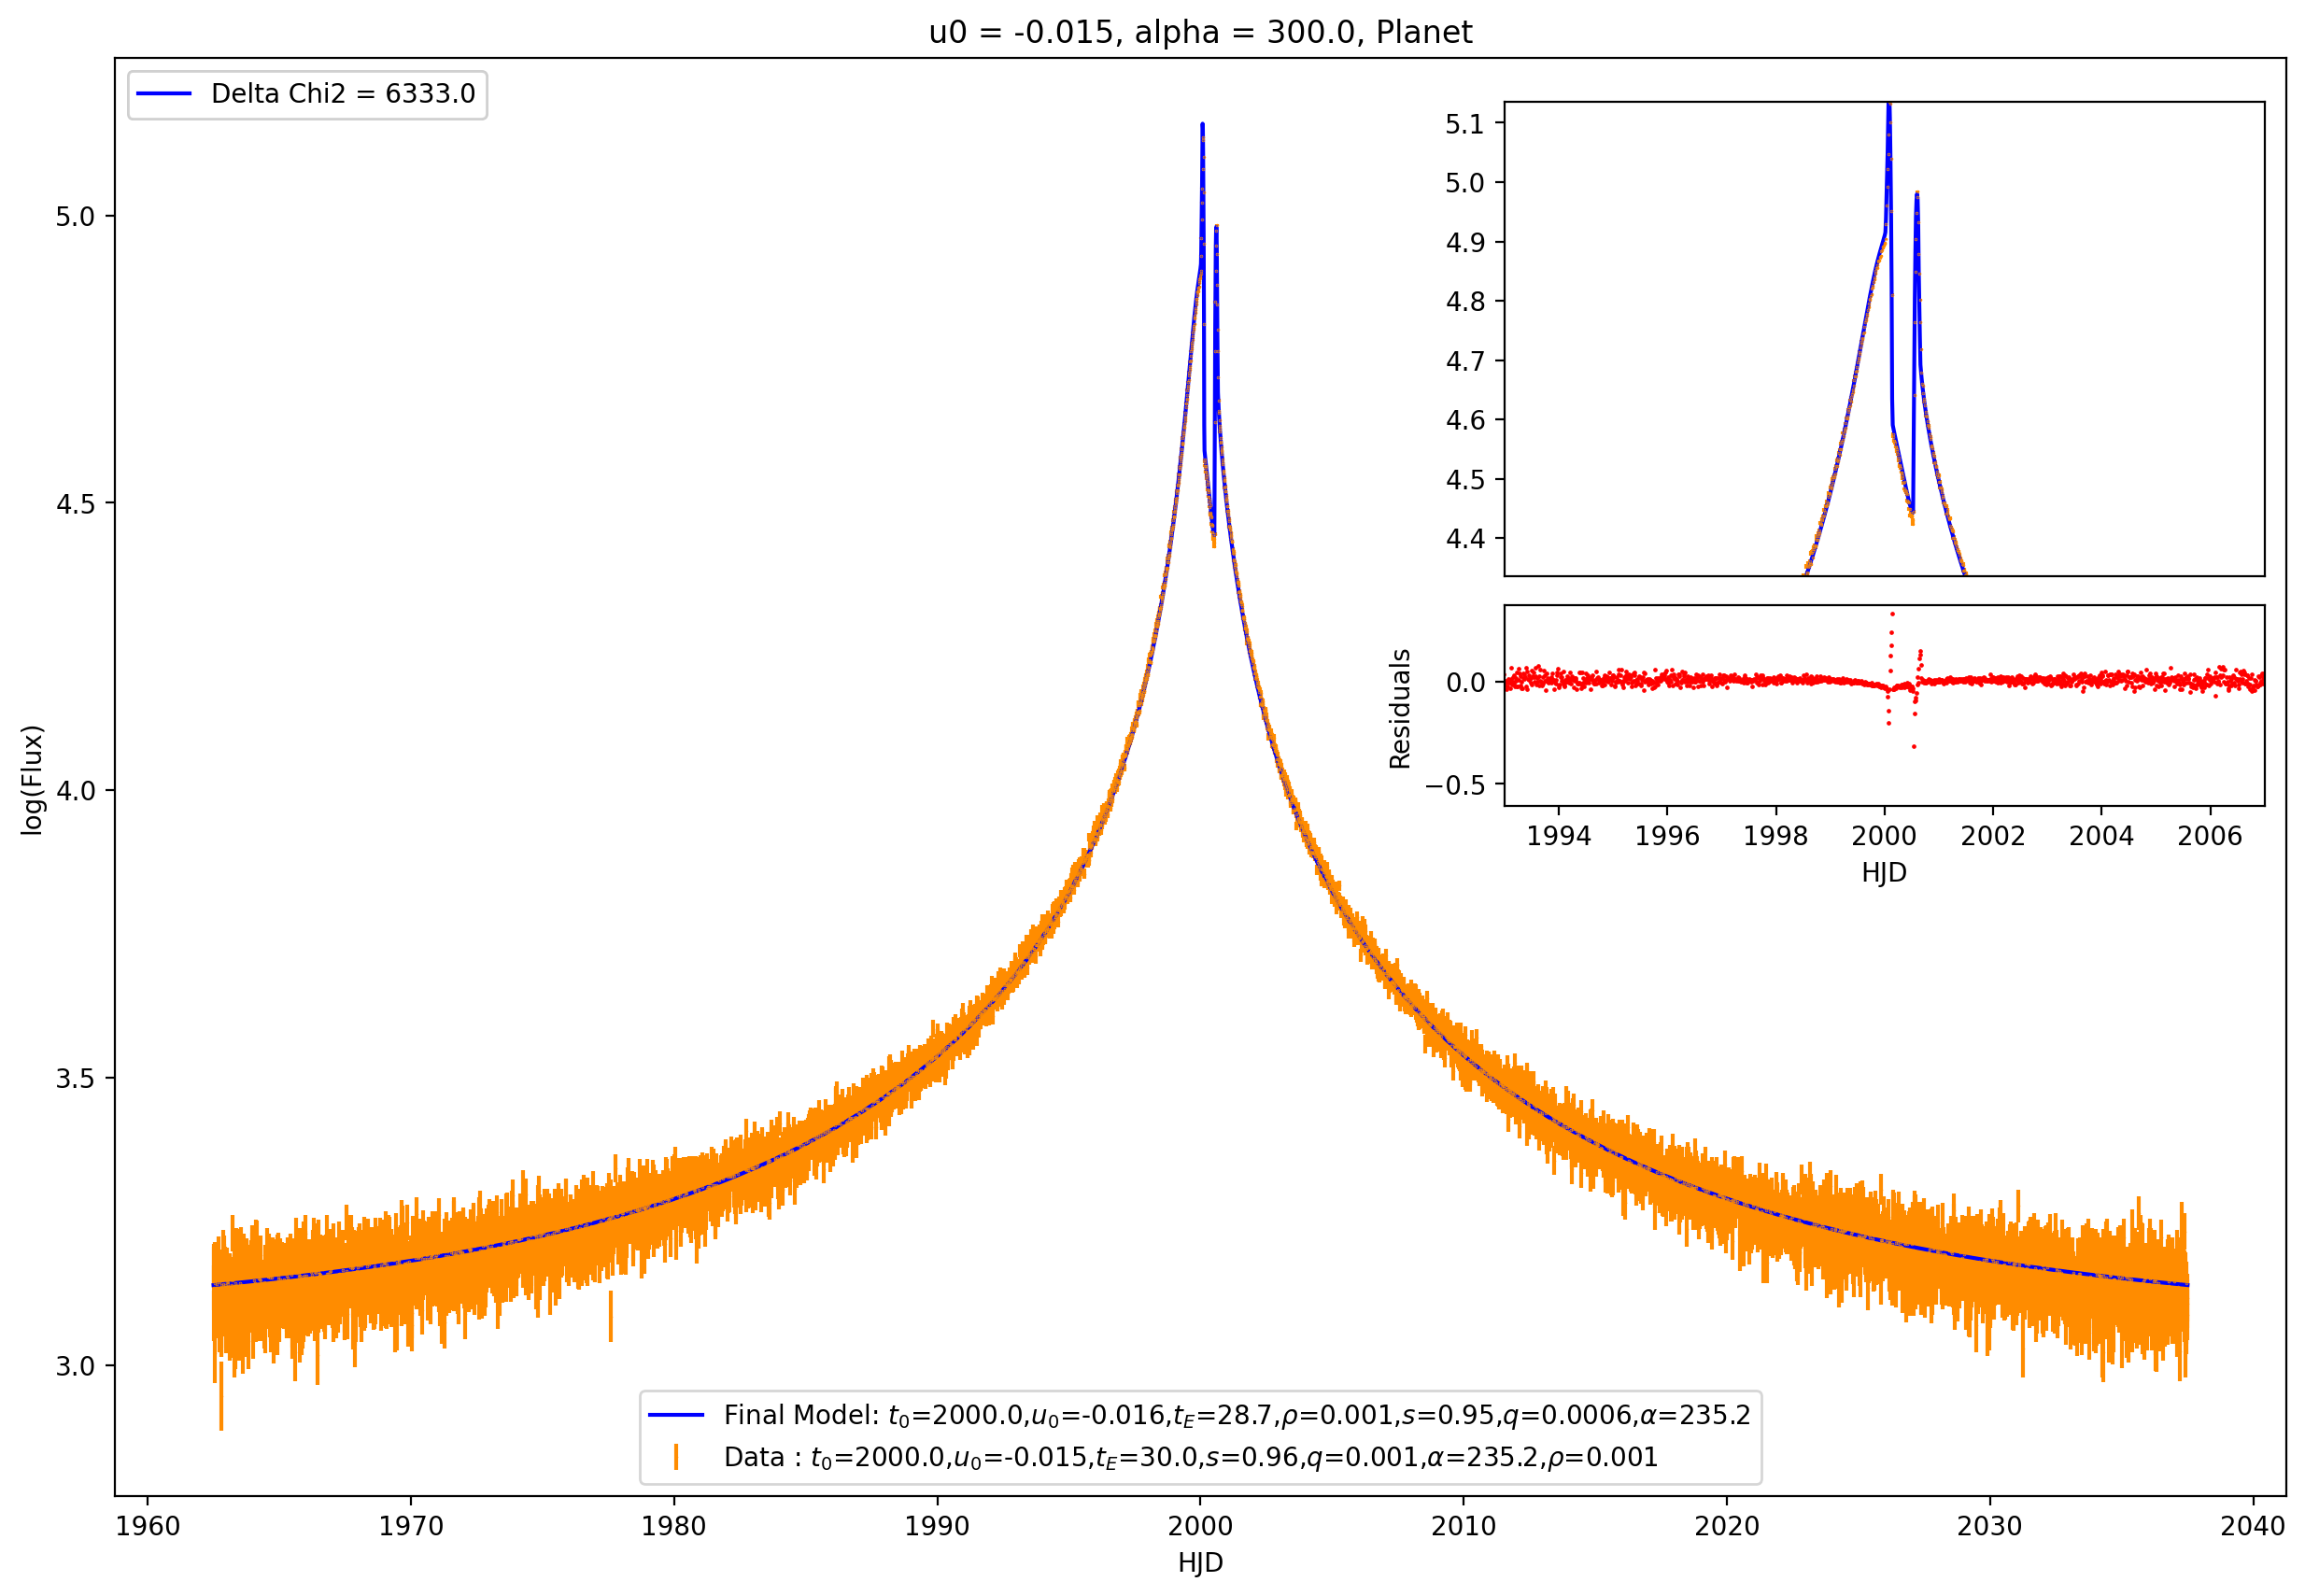

In [3]:

#Plot the model



#falphal, fu0l, binplan = np.loadtxt("../Multiple_lc_run1_fits/Binaryfit_fail.txt", usecols=[0,1,2], unpack=True, dtype=str)
#for i in range(len(falphal)):
binplan = ["Planet"]
i = 0

falpha = 60.0#float(falphal[i])
alpha = 360.0 - falpha
fu0 = -0.015 #float(fu0l[i])
file_name = "../Multiple_lc_run1/s20p2s31p0psi60.0alpha%.1f/u%.3falpha%d"%(falpha,fu0,alpha)
table = []
with open("../Multiple_lc_run1_fits/s20p2s31p0psi60.0alpha%.1f/u%.3falpha%d.txt"%(falpha,fu0,alpha)) as f:
    # reading each line
    j = 0    
    for line in f:
        #if i==0:
            #continue
        table.append([])
        # reading each word        
        for word in line.split():
            table[j].append(word)
        j +=1

if binplan[i] == "Binary":
    #Read binary data
    hjd, binaryflux, binaryflux_err = np.loadtxt(file_name+"_binflux.txt", usecols=[0,1,2], unpack=True)
    my_data_bin = mm.MulensData([hjd, binaryflux, binaryflux_err], phot_fmt="flux", chi2_fmt="flux")
    true_params = np.loadtxt(file_name+"_bininfo.txt", skiprows=1)
    params_bin = {"t_0": true_params[0], "u_0": true_params[1], "t_E": true_params[2], "s": true_params[3], "q": true_params[4], "alpha": true_params[5], "rho": true_params[6]}
    for row in table:
        if ('Binary-Binary' in row and 'Initial' in row) or ('Initial-Binary' in row and 'only' in row):
            bi = row
        if ('Binary-Binary' in row and 'Final' in row) or ('Final-Binary' in row and 'only' in row):
            bf = row
    
elif binplan[i] == "Planet":
    #Read planet data
    hjd, planetflux, planetflux_err = np.loadtxt(file_name+"_planetflux.txt", usecols=[0,1,2], unpack=True)
    my_data_bin = mm.MulensData([hjd, planetflux, planetflux_err], phot_fmt="flux", chi2_fmt="flux")
    true_params = np.loadtxt(file_name+"_planetinfo.txt", skiprows=1)
    params_bin = {"t_0": true_params[0], "u_0": true_params[1], "t_E": true_params[2], "s": true_params[3], "q": true_params[4], "alpha": true_params[5], "rho": true_params[6]}
    for row in table:
        if ('Planet-Planet' in row and 'Initial' in row) or ('Initial-Planet' in row and 'only' in row):
            bi = row
        if ('Planet-Planet' in row and 'Final' in row) or ('Final-Planet' in row and 'only' in row):
            bf = row


params_bininit = {'t_0': float(bi[0]), 'u_0': float(bi[1]), 't_E': float(bi[2]), 's': float(bi[4]), 'q': float(bi[5]), 'alpha': float(bi[6]), 'rho': float(bi[3]), 'sf': float(bi[7]), 'bf': float(bi[8])}
params_binfinal = {'t_0': float(bf[0]), 'u_0': float(bf[1]), 't_E': float(bf[2]), 's': float(bf[4]), 'q': float(bf[5]), 'alpha': float(bf[6]), 'rho': float(bf[3]), 'sf': float(bf[7]), 'bf': float(bf[8])}
chisq = float(bf[9])
plot_init_final(params_bininit, params_binfinal, my_data_bin, params_bin, chisq, binplan[i], alpha)

In [72]:





#p = np.genfromtxt("../Multiple_lc_run1_fits/s20p2s31p0psi60.0alpha0.0/u0.000alpha360.txt", filling_values = np.nan, skip_header=1, delimiter=None)
#print(p)

1
2
3
4
5
6
7
8
9
10
11


['2000.2', '0.0970', '30.75', '0.00103', '0.933', '0.00053', '294.73', '1079.2', '22.2', '12920.8', 'Initial-Planet', 'only']


In [20]:
params_planetfinal

{'t_0': 2000.0,
 'u_0': -0.0896,
 't_E': 31.13,
 's': 0.965,
 'q': 0.0005,
 'alpha': 291.68,
 'rho': 0.00113,
 'sf': 1022.7,
 'bf': 79.2}

{'t_0': 2000.0024398481098,
 'u_0': -0.10265585911220264,
 't_E': 29.477433902642414,
 's': 0.9561357050982987,
 'q': 0.0005498165556134929,
 'alpha': 235.376682137087,
 'rho': 0.0010287038695106553}

In [85]:
alphaplanet

235.23181320967728

In [ ]:
#Plot the binary and planetary models

import matplotlib.lines as mlines

def plot_init_final(binmodel, planetmodel):
    fig, ax = plt.subplots(figsize = (15,10), dpi = 200) 


    dat = ax.errorbar(my_data.time, np.log10(my_data.flux), yerr=my_data.err_flux/(my_data.flux*np.log(10)), fmt= '.', color='darkorange', markersize=0.5, label = r'Data : $t_0$=%.1f,$u_0$=%.3f,$t_E$=%.1f,$s_2$=%0.2f,$q_2$=%0.3f,$\alpha$=%0.1f,$\rho$=%0.3f,$s_3$=%.2f,$q_3$=%.3f,$\psi$=%.1f'%(params_cb["t_0"],params_cb["u_0"],params_cb["t_E"],params_cb["s2"],params_cb["q2"],params_cb["alpha"],params_cb["rho"],params_cb["s3"],params_cb["q3"],params_cb["psi"]))
    ax.set_xlabel('HJD')
    ax.set_ylabel('log(Flux)')
    ax.set_title('Best Fit Binary and Planetary Models')
    plt.legend(loc='best')

    ax.plot(my_data.time, np.log10(binmodel), color='blue', linestyle='--', markersize=0.5, label = "Binary Model")
    mod = ax.plot(my_data.time, np.log10(planetmodel), color='red', linestyle='-', markersize=0.5, label= r'Final Model: $t_0$=%.1f,$u_0$=%.3f,$t_E$=%.1f,$\rho$=%0.3f,$s$=%0.2f,$q$=%0.4f,$\alpha$=%0.1f'%(result.x[0], result.x[1], result.x[2], result.x[3], result.x[4], result.x[5], result.x[6]))
    blue_line = mlines.Line2D([], [], color='blue', label='Model Chi2 = %.1f'%(result_fun))
    handles, labels = ax.get_legend_handles_labels()
    legend1 = ax.legend(handles, labels, loc='lower center')
    ax.add_artist(legend1)
    legend2 = ax.legend(handles = [blue_line], loc='upper left')
    ax.add_artist(legend2)

    # inset axes....
    x1, x2, y1, y2 = 1993, 2007, np.log10(np.max(my_data.flux)) - 0.8, np.log10(np.max(my_data.flux))  # subregion of the original image
    axins = ax.inset_axes(
        [0.64,0.64,0.35,0.33],
        xlim=(x1, x2), ylim=(y1, y2), xticks=[])
    axins.errorbar(my_data.time, np.log10(my_data.flux), yerr=my_data.err_flux/(my_data.flux*np.log(10)), fmt= '.', color='darkorange', markersize=0.5)
    axins.plot(my_data.time, np.log10(binmodel), color='blue', linestyle='--', markersize=0.5)
    axins.plot(my_data.time, np.log10(), color='blue', linestyle='-', markersize=0.5)
    #ax.indicate_inset_zoom(axins, edgecolor="black")

    #find residuals
    residuals = (my_data.flux - lcfluxfin)/my_data.flux
    axins2 = ax.inset_axes(
        [0.64,0.48,0.35,0.14],
        xlim=(x1, x2))
    axins2.scatter(my_data.time, residuals , color='red', label = 'Residuals', s=0.5)
    axins2.set_xlabel('HJD')
    axins2.set_ylabel('Residuals')
    plt.subplots_adjust(hspace=0.1)
    #plt.savefig('../Plots/circumbinary/Fitting/%s%d_final3_fitnm.png'%(type,index))

1111.346916813033 23.86317723838464
13937.235767587992


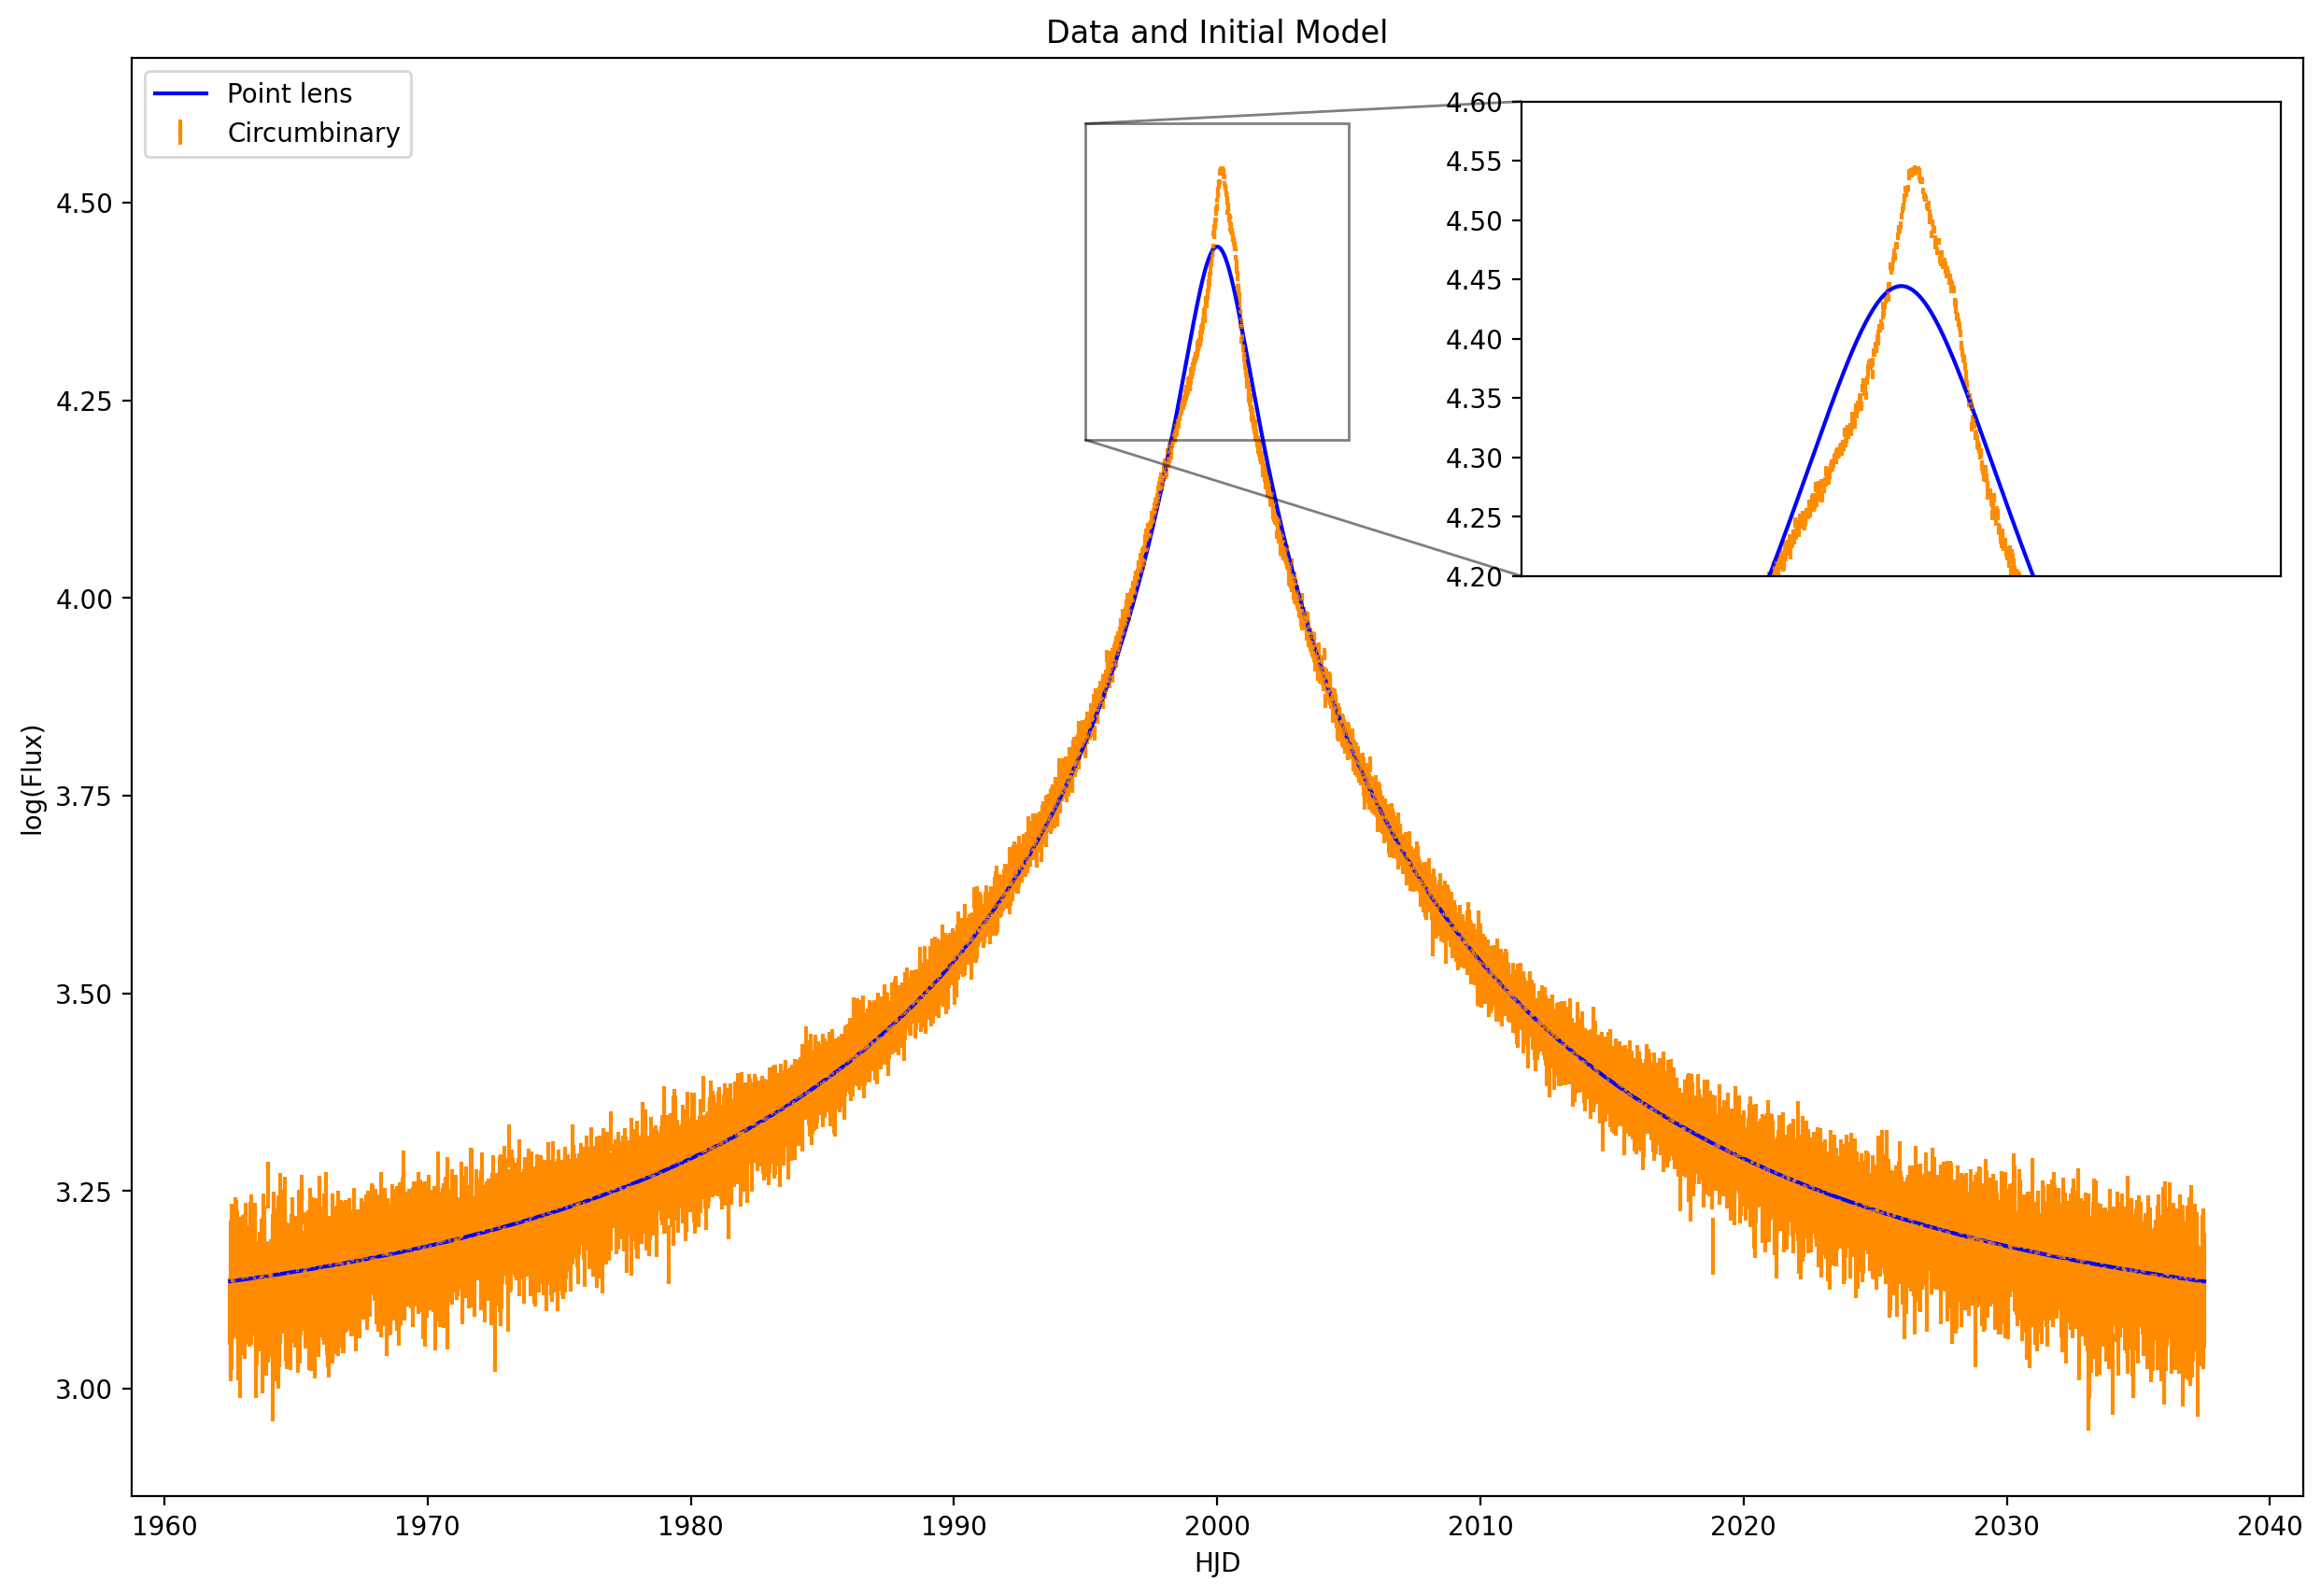

In [173]:
#zpt = 25.0
#mm.utils.MAG_ZEROPINT = zpt

#true_params = [4000.0, 0.010, 20.0, 0.001, 0.7, 0.001, 260.0]
t_0 = 2000.0 #2000.5
u_0 = -0.040 #-0.041
t_E = 30.0 # This is in days.
rho = 0.001
s = 0.20#0.17
q = 0.85
alpha = 80.0
gamma = 1.25
planet_model = mm.Model({'t_0': t_0, 'u_0': u_0, 't_E': t_E, 'rho': rho, 's': s, 'q': q, 'alpha': alpha})
planet_model.set_magnification_methods([t_0 - gamma*t_E, 'VBBL', t_0 + gamma*t_E])
psplmodel = mm.Model({'t_0': t_0, 'u_0': u_0, 't_E': t_E})
my_event = mm.Event(datasets=[my_data], model=planet_model)


fig, ax = plt.subplots(figsize = (15,10), dpi = 200) #sharex={'row'},height_ratios=[3,1],2,1, figsize=(10,10)


ax.errorbar(my_data.time, np.log10(my_data.flux), yerr=my_data.err_flux/(my_data.flux*np.log(10)), fmt= '.', color='darkorange', markersize=0.5, label = "Circumbinary")#label = r'$t_0$=%.1f,$u_0$=%.3f,$t_E$=%.1f,s=%0.2f,q=%0.3f,$\alpha$=%0.1f,$\rho$=%0.3f'%(true_params[0],true_params[1],true_params[2],true_params[3],true_params[4],true_params[5],true_params[6]))
#ax[0].set_yscale('log')
ax.set_xlabel('HJD')
ax.set_ylabel('log(Flux)')
ax.set_title('Data and Initial Model')
plt.legend(loc='best')
init_fit = mm.FitData(dataset=my_data, model=psplmodel)
init_fit.fit_fluxes()
sourceflux = init_fit.source_flux
blendflux = init_fit.blend_flux
lcmag = psplmodel.get_lc(my_data.time, source_flux=sourceflux, blend_flux=blendflux)
lcflux = mm.Utils.get_flux_from_mag(lcmag)
ax.plot(my_data.time, np.log10(lcflux), color='blue', linestyle='-', markersize=0.5, label = "Point lens")#label= r'$t_0$=%.1f,$u_0$=%.3f,$t_E$=%.1f,$\rho$=%0.3f,s=%0.2f,q=%0.3f,$\alpha$=%0.1f'%(t_0,u_0,t_E,rho,s,q,alpha))
ax.legend(loc='best')

# inset axes....
x1, x2, y1, y2 = 1995, 2005, 4.2, 4.6  # subregion of the original image
axins = ax.inset_axes(
    [0.64,0.64,0.35,0.33],
    xlim=(x1, x2), ylim=(y1, y2), xticks=[])
axins.errorbar(my_data.time, np.log10(my_data.flux), yerr=my_data.err_flux/(my_data.flux*np.log(10)), fmt= '.', color='darkorange', markersize=0.5)
axins.plot(my_data.time, np.log10(lcflux), color='blue', linestyle='-', markersize=0.5)
ax.indicate_inset_zoom(axins, edgecolor="black")



"""
#find residuals
residuals = np.abs((my_data.flux - lcflux)/lcflux)
axins2 = ax.inset_axes(
    [0.64,0.48,0.35,0.14],
    xlim=(x1, x2), ylim=(-2,1))
axins2.scatter(my_data.time, np.log10(residuals) , color='red', label = 'Residuals', s=0.5)
axins2.set_xlabel('HJD')
axins2.set_ylabel('log(Residuals)')
#axins2.set_xlabel('HJD')
#axins2.set_ylabel('log(Residuals)')
"""
#ax[1].set_yscale('log')
#ax[1].legend(loc='best')
#plt.gca().invert_yaxis()
plt.subplots_adjust(hspace=0.1)
#plt.savefig('../Plots/circumbinary/Fitting/%s%d_initial3_fitnm.png'%(type,index))
#my_event.plot_data(markersize=2, phot_fmt='mag', show_errorbars=True, color = 'red')
#my_event.plot_model()
#plt.gca().invert_yaxis()
print(sourceflux, blendflux)
print(my_event.get_chi2())


In [163]:
import scipy.optimize as op
from scipy.optimize import Bounds


parameters_to_fit = ["t_0", "u_0", "t_E", "rho", "s", "q", "alpha"]
#initial_guess = [t_0, u_0, t_E, rho, s, q, alpha]
bounds = ((0.,10000), (-10.0, 10.0), (0., 100.), (0.0, 1.0), (0.0, 100.0),(0.0, 1.0), (0., 360.)) #uo = , q =  u0 = (-0.1,0.1) q = (0.1, 0.999)
#bounds2 = (np.array([3997, -0.01, 1., 0.0001, 0.1, 0.0001, 0.]), np.array([4004, 0.01, 40., 0.01, 2., 0.01, 360.]))

#result = op.least_squares(chi2_for_model, x0 = initial_guess,bounds=bounds2,args=(my_event, parameters_to_fit),ftol=1e-12,xtol=1e-12,x_scale=np.array([4000., 0.001, 10, 0.001, 0.1, 0.001, 1. ]), method = 'trf') #mutation=(0.5,1),recombination=0.6,disp=True,polish=True, init = "sobol", atol=0.1, popsize=10
#result = op.minimize(chi2_for_model, x0=initial_guess,
        #args=(my_event, parameters_to_fit), method='trust-constr', bounds=bounds) #options={'ftol': 1e-8, 'disp': True}
#result = op.differential_evolution(chi2_for_model, bounds, args=(my_event, parameters_to_fit), init='sobol', x0 = initial_guess, mutation=(0.5,1),recombination=0.6,disp=True,polish=True, atol=0.1, popsize=10)

result = fit_model(my_event, parameters_to_fit, bounds)
#my_event.fit_fluxes()

print("Fitting was successful? {:}".format(result.success))
if not result.success:
    print(result.message)
print("Function evaluations: {:}".format(result.nfev))
if isinstance(result.fun, np.ndarray):
    if result.fun.ndim == 0:
        result_fun = float(result.fun)
    else:
        result_fun = result.fun[0]
else:
    result_fun = result.fun
print("The smallest function value: {:.3f}".format(result_fun))
print("for parameters: {:.5f} {:.4f} {:.3f} {:.3f} {:.3f} {:.4f} {:.2f}".format(*result.x.tolist()))

#report_fit(result, modelpars=params_t, correl_mode='table')

sourceflux = my_event.get_ref_fluxes()[0]
blendflux = my_event.get_ref_fluxes()[1]
print("Magnitude: %.5f %.5f"%(mm.Utils.get_mag_from_flux(sourceflux),mm.Utils.get_mag_from_flux(blendflux)))
# Initial model:
#pspl_model.parameters.t_0 = t_0
#pspl_model.parameters.u_0 = u_0
#pspl_model.parameters.t_E = t_E
#my_event.plot_model(label='initial', c='red')
# Best fitting model:
"""
planet_model.parameters.t_0 = result.x[0]
planet_model.parameters.u_0 = result.x[1]
planet_model.parameters.t_E = result.x[2]
planet_model.parameters.rho = result.x[3]
planet_model.parameters.s = result.x[4]
planet_model.parameters.q = result.x[5]
planet_model.parameters.alpha = result.x[6]
"""




Fitting was successful? False
Maximum number of function evaluations has been exceeded.
Function evaluations: 5000
The smallest function value: 10553.695
for parameters: 2000.00964 -0.0493 24.822 0.001 0.218 0.6314 77.95
Magnitude: 14.15039 nan


/Users/murlidhar.4/Documents/Projects/microlens/.venv/lib/python3.9/site-packages/MulensModel/utils.py:114: UserWarning:

Flux to magnitude conversion approached negative flux

/Users/murlidhar.4/Documents/Projects/microlens/.venv/lib/python3.9/site-packages/MulensModel/utils.py:117: RuntimeWarning:

invalid value encountered in log10

/var/folders/hn/6p7kgmw55kn4chlmx3c4v4pw0000gp/T/ipykernel_81927/274105638.py:36: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



'\nplanet_model.parameters.t_0 = result.x[0]\nplanet_model.parameters.u_0 = result.x[1]\nplanet_model.parameters.t_E = result.x[2]\nplanet_model.parameters.rho = result.x[3]\nplanet_model.parameters.s = result.x[4]\nplanet_model.parameters.q = result.x[5]\nplanet_model.parameters.alpha = result.x[6]\n'

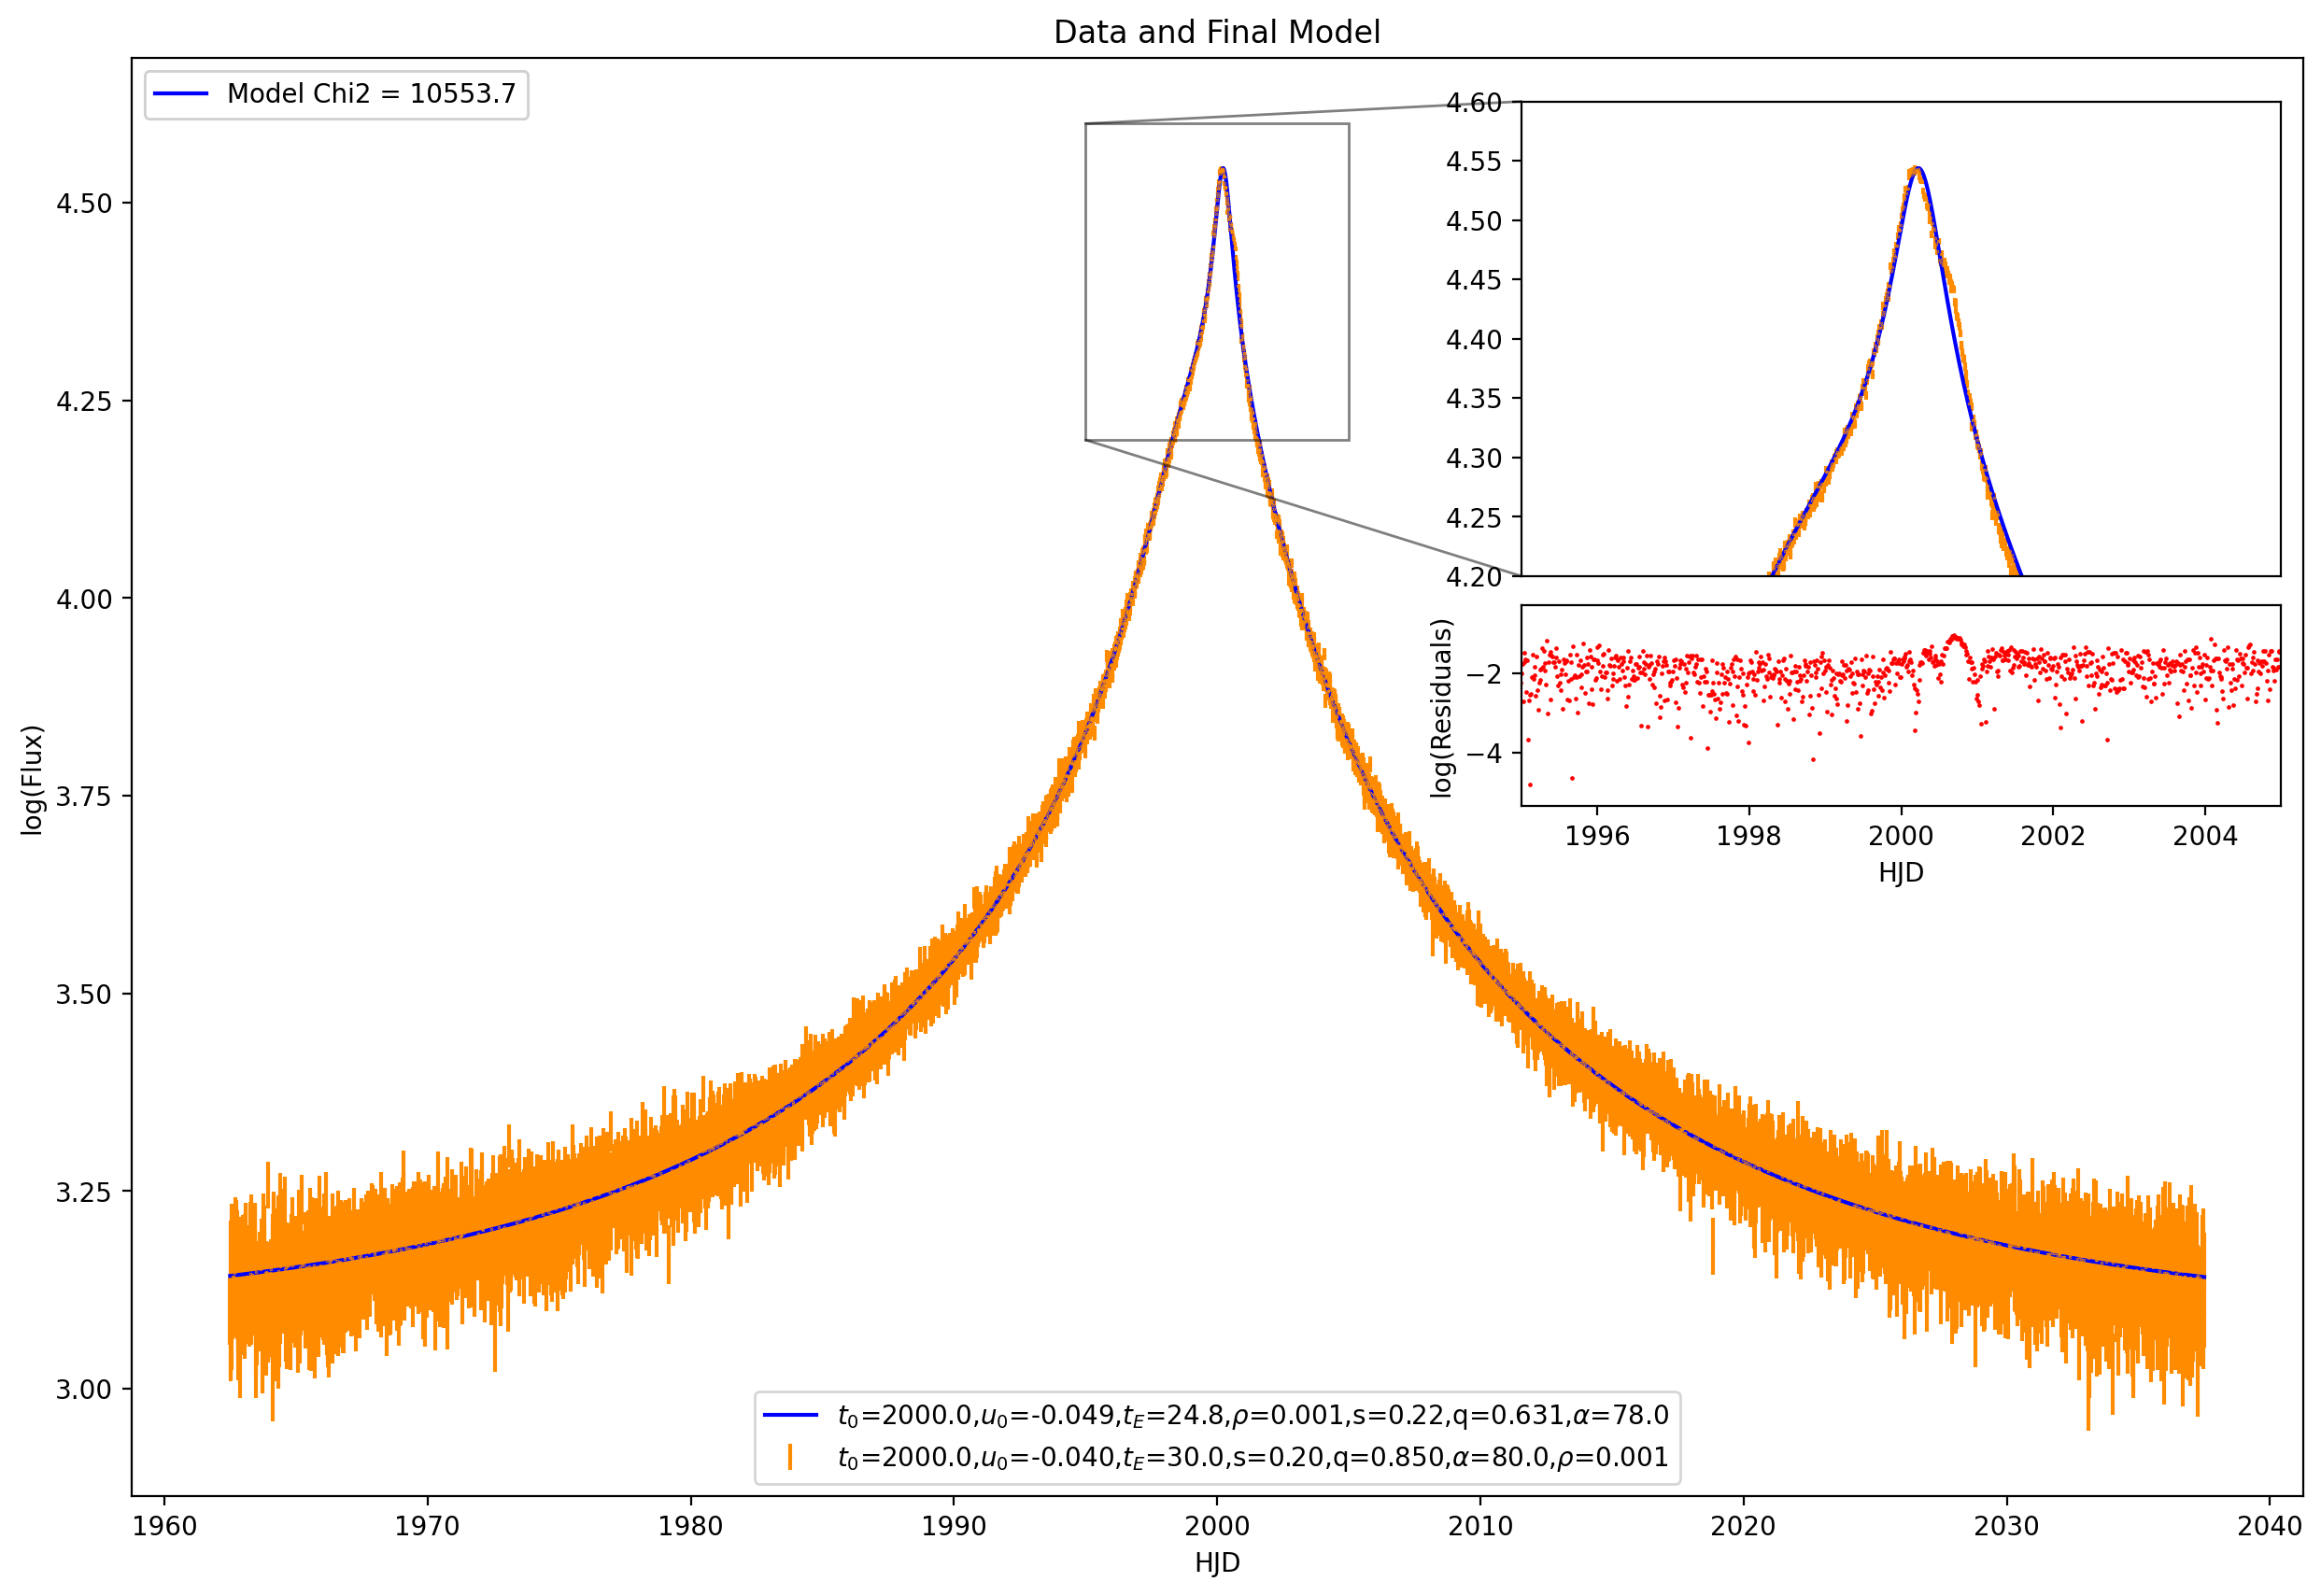

In [164]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize = (15,10), dpi = 200)#(2,1,sharex={'row'},height_ratios=[3,1], figsize=(10,10))


dat = ax.errorbar(my_data.time, np.log10(my_data.flux), yerr=my_data.err_flux/(my_data.flux*np.log(10)), fmt= '.', color='darkorange', markersize=0.5, label = r'$t_0$=%.1f,$u_0$=%.3f,$t_E$=%.1f,s=%0.2f,q=%0.3f,$\alpha$=%0.1f,$\rho$=%0.3f'%(true_params[0],true_params[1],true_params[2],true_params[3],true_params[4],true_params[5],true_params[6]))
#ax[0].set_yscale('log')
#ax[0].set_xlabel('HJD')
ax.set_ylabel('log(Flux)')
ax.set_title('Data and Final Model')
plt.legend(loc='best')

sourceflux, blendflux = my_event.get_ref_fluxes()
lcmag = my_event.model.get_lc(my_data.time, source_flux=sourceflux, blend_flux=blendflux)
lcflux = mm.Utils.get_flux_from_mag(lcmag)
mod = ax.plot(my_data.time, np.log10(lcflux), color='blue', linestyle='-', markersize=0.5, label= r'$t_0$=%.1f,$u_0$=%.3f,$t_E$=%.1f,$\rho$=%0.3f,s=%0.2f,q=%0.3f,$\alpha$=%0.1f'%(result.x[0], result.x[1], result.x[2], result.x[3], result.x[4], result.x[5], result.x[6])) #  (result.params['t_0'].value,result.params['u_0'].value,result.params['t_E'].value,result.params['rho'].value,result.params['s'].value,result.params['q'].value,result.params['alpha'].value)
blue_line = mlines.Line2D([], [], color='blue', label='Model Chi2 = %.1f'%(result_fun))#  result.chisqr
handles, labels = ax.get_legend_handles_labels()
legend1 = ax.legend(handles, labels, loc='lower center')
ax.add_artist(legend1)
legend2 = ax.legend(handles = [blue_line], loc='upper left')
ax.add_artist(legend2)
ax.set_xlabel('HJD')
# inset axes....
x1, x2, y1, y2 = 1995, 2005, 4.2, 4.6  # subregion of the original image
axins = ax.inset_axes(
    [0.64,0.64,0.35,0.33],
    xlim=(x1, x2), ylim=(y1, y2), xticks=[])
axins.errorbar(my_data.time, np.log10(my_data.flux), yerr=my_data.err_flux/(my_data.flux*np.log(10)), fmt= '.', color='darkorange', markersize=0.5)
axins.plot(my_data.time, np.log10(lcflux), color='blue', linestyle='-', markersize=0.5)
ax.indicate_inset_zoom(axins, edgecolor="black")

#find residuals
residuals = np.abs((my_data.flux - lcflux)/lcflux)
axins2 = ax.inset_axes(
    [0.64,0.48,0.35,0.14],
    xlim=(x1, x2))
axins2.scatter(my_data.time, np.log10(residuals) , color='red', label = 'Residuals', s=0.5)
axins2.set_xlabel('HJD')
axins2.set_ylabel('log(Residuals)')
#ax[1].set_xlabel('HJD')
#ax[1].set_ylabel('log(Residuals)')
#ax[1].set_yscale('log')
#leg = ax[1].legend(handles = [res], loc='best')
#ax[1].add_artist(leg)
#plt.gca().invert_yaxis()
plt.subplots_adjust(hspace=0.1)
plt.savefig('../Plots/circumbinary/Fitting/%s%d_final3_fitnm.png'%(type,index))


1123

    t_0 (HJD)       u_0    t_E (d)     rho         s            q alpha (deg) 
   4000.00143 -0.007648     6.9699 0.09773   0.54245   0.80294312   269.84357 
default magnification method: point_source
other magnification methods: [3957.8, 'VBBL', 4044.2]

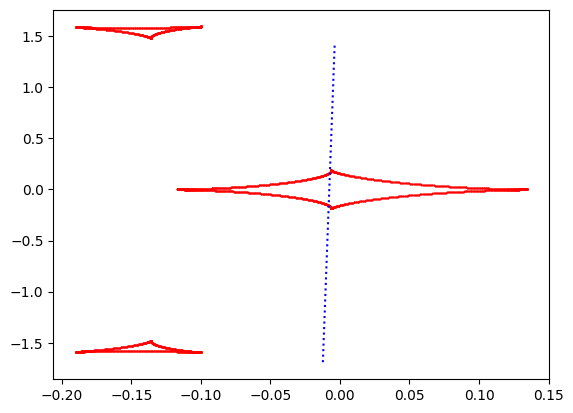

In [48]:
planet_model_final = mm.Model({'t_0': result.params['t_0'].value, 'u_0': result.params['u_0'].value, 't_E': result.params['t_E'].value, 'rho': result.params['rho'].value, 's': result.params['s'].value, 'q': result.params['q'].value, 'alpha': result.params['alpha'].value})
planet_model_final.set_magnification_methods([t_0 - gamma*t_E, 'VBBL', t_0 + gamma*t_E])

planet_model_final.plot_caustics(color='red', linestyle='-', s = 1.7)
planet_model_final.plot_trajectory(t_range=[t_0 - 1.*t_E, t_0 + 1.*t_E], 
                       caustics=False, arrow=False, color='blue', linestyle=':') 

#plt.xlim(-0.015,0.015)
#lt.ylim(-0.015,0.015)
planet_model_final

Rename cb lc files by replacing 329 with 330

In [6]:
import os

# Specify the folder containing the files
folder_path = '../Multiple_lc_run2/s20p2s30p9psi60.0alpha30.0/'

# Loop over the files in the folder
for filename in os.listdir(folder_path):
    print(filename)
    # Check if "329" is in the filename
    if '329' in filename:
        # Construct the new filename by replacing "329" with "330"
        new_filename = filename.replace('329', '330')
        
        # Get full file paths
        old_file = os.path.join(folder_path, filename)
        new_file = os.path.join(folder_path, new_filename)
        
        # Rename the file
        os.rename(old_file, new_file)
        print(f'Renamed: {old_file} -> {new_file}')


u0.125alpha329_bininfo.txt
Renamed: ../Multiple_lc_run2/s20p2s30p9psi60.0alpha30.0/u0.125alpha329_bininfo.txt -> ../Multiple_lc_run2/s20p2s30p9psi60.0alpha30.0/u0.125alpha330_bininfo.txt
u0.400alpha330_planetinfo.txt
u-0.200alpha330_bininfo.txt
u0.375alpha329_planetflux.txt
Renamed: ../Multiple_lc_run2/s20p2s30p9psi60.0alpha30.0/u0.375alpha329_planetflux.txt -> ../Multiple_lc_run2/s20p2s30p9psi60.0alpha30.0/u0.375alpha330_planetflux.txt
u-0.300alpha330_lc.png
u-0.275alpha329_planetflux.txt
Renamed: ../Multiple_lc_run2/s20p2s30p9psi60.0alpha30.0/u-0.275alpha329_planetflux.txt -> ../Multiple_lc_run2/s20p2s30p9psi60.0alpha30.0/u-0.275alpha330_planetflux.txt
u-0.175alpha329_bininfo.txt
Renamed: ../Multiple_lc_run2/s20p2s30p9psi60.0alpha30.0/u-0.175alpha329_bininfo.txt -> ../Multiple_lc_run2/s20p2s30p9psi60.0alpha30.0/u-0.175alpha330_bininfo.txt
u-0.175alpha329_lc.png
Renamed: ../Multiple_lc_run2/s20p2s30p9psi60.0alpha30.0/u-0.175alpha329_lc.png -> ../Multiple_lc_run2/s20p2s30p9psi60.0alpha

Test Binary Fitting 

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import MulensModel as mm
import scipy.optimize as op
import astropy.units as u
from scipy.optimize import Bounds
import matplotlib.lines as mlines
from iminuit import Minuit
from iminuit import minimize as iminuit_minimize
from scipy.optimize import OptimizeResult
import time
import multiprocessing
from Plot_binary_models import plot_init_final

def magtoflux(mag, zeropint = 27.615):
    return 10.**(-0.4*(mag - zeropint))

def chi2_for_model(theta, event, parameters_to_fit, data_ref):
    """
    for given event set attributes from parameters_to_fit
    (list of str) to values from the theta list
    """
    for (index, key) in enumerate(parameters_to_fit):
        if (key == 't_E' or key =='rho') and theta[index] < 0.:
            return np.inf
        setattr(event.model.parameters, key, theta[index])
    return event.get_chi2_for_dataset(data_ref)

def fit_model(event, parameters_to_fit, bounds = None, data_ref = 0):
    """
    Fit an "event" with "parameters_to_fit" as free parameters.
    
    event = a MulensModel event
    parameters_to_fit = list of parameters to fit
    """
    # Take the initial starting point from the event.
    x0 = []
    for key in parameters_to_fit:
        value = getattr(event.model.parameters, key)
        if isinstance(value, u.Quantity):
            x0.append(value.value)
        else:
            x0.append(value)

    # *Execute fit using a 'Nelder-Mead' algorithm*
    result = op.minimize(
       chi2_for_model, x0, args=(event, parameters_to_fit, data_ref), bounds=bounds,
       method='Nelder-Mead', options={'xatol': 1e-8, 'fatol': 1e-8, 'adaptive': False, 'maxfev' : 1000}) #10^-14, 5000
    #result = op.minimize(chi2_for_model, x0, args=(event, parameters_to_fit), method= 'L-BFGS-B' , options={'ftol': 1e-14, 'gtol': 1e-14, 'maxfun': 2000}, bounds=bounds)

    return result

def find_residuals(params, event, parameters_to_fit):
    for (index, key) in enumerate(parameters_to_fit):
        setattr(event.model.parameters, key, params[key].value)
    event.fit_fluxes()
    srcflux, bldflux = event.get_ref_fluxes()
    modelmag = event.model.get_lc(event.datasets[0].time, source_flux=srcflux, blend_flux=bldflux)
    modelflux = mm.Utils.get_flux_from_mag(modelmag)
    residuals = (event.datasets[0].flux - modelflux) / event.datasets[0].err_flux
    return residuals  

def fit_model_minuit(event, parameters_to_fit, bounds = None, data_ref = 0):
    """
    Fit an "event" with "parameters_to_fit" as free parameters.
    
    event = a MulensModel event
    parameters_to_fit = list of parameters to fit
    """
    # Take the initial starting point from the event.
    x0 = []
    for key in parameters_to_fit:
        value = getattr(event.model.parameters, key)
        if isinstance(value, u.Quantity):
            x0.append(value.value)
        else:
            x0.append(value)
    
    def wrapped(func, args):
        return lambda x: func(x, *args)
    
    chisq_wrapped = wrapped(chi2_for_model, (event, parameters_to_fit, data_ref))
    chisq_wrapped.errordef = 1.0
    m = Minuit(chisq_wrapped, x0)
    m.limits = bounds
    m.tol = 0.0001 #0.0001
    m.strategy = 1
    m.simplex(ncall=500) #5000
    m.strategy = 1
    m.tol = 0.1 #0.0001
    m.migrad(ncall = 500) #5000
    end_time = time.time()
    if m.valid:
        message = "Optimization terminated successfully"
        if m.accurate:
            message += "."
        else:
            message += ", but uncertainties are unrealiable."
    else:
        message = "Optimization failed."
        fmin = m.fmin
        if fmin.has_reached_call_limit:
            message += " Call limit was reached."
        if fmin.is_above_max_edm:
            message += " Estimated distance to minimum too large."

    n = len(x0)
    result = OptimizeResult(
        x=np.array(m.values),
        success=m.valid,
        fun=m.fval,
        hess_inv=m.covariance if m.covariance is not None else np.ones((n, n)),
        message=message,
        nfev=m.nfcn,
        njev=m.ngrad,
        minuit=m,
    )

    return result


def fit_pspl_planet(my_data_planet, params_planet, params_bin, true_chisq, falpha, fu0, alpha, q):    
    t_0 = params_bin['t_0']
    u_0 = params_bin['u_0']
    t_E = params_bin['t_E']
    rho = params_bin['rho']
    splanet = params_planet['s']
    qplanet = params_planet['q']
    alphaplanet = params_planet['alpha']
    u0planet = params_planet['u_0']
    gamma = 1.25

    pspl_model = mm.Model({'t_0': t_0, 'u_0': u_0, 't_E': t_E, 'rho': rho})
    pspl_model.set_magnification_methods([t_0 - gamma*t_E, 'finite_source_uniform_Gould94', t_0 + gamma*t_E])
    planet_model = mm.Model({'t_0': t_0, 'u_0': u0planet, 't_E': t_E, 's': splanet, 'q': qplanet, 'alpha': alphaplanet, 'rho': rho})
    planet_model.set_magnification_methods([t_0 - gamma*t_E, 'VBBL', t_0 + gamma*t_E])

    #Fit planetary LC with planet model
    print("Fitting planet-planet u_0 %.3f"%(u_0))
    start_time = time.time()
    flagplanet = 0
    sgns = np.random.choice([-1,1], size = 7)
    planet2_model = mm.Model({'t_0': t_0 + sgns[0]*0.25, 'u_0': u0planet + sgns[1]*0.025*u0planet, 't_E': t_E + sgns[2]*0.025*t_E, 's': splanet + sgns[3]*0.025*splanet, 'q': qplanet + sgns[4]*0.025*qplanet, 'alpha': alphaplanet + sgns[5]*0.5, 'rho': rho + sgns[6]*0.025*rho})
    planet2_model.set_magnification_methods([t_0 - gamma*t_E, 'VBBL', t_0 + gamma*t_E])
    params_planetinit = {'t_0': t_0, 'u_0': u0planet + sgns[1]*0.025*u0planet, 't_E': t_E, 's': splanet + sgns[3]*0.025*splanet, 'q': qplanet + sgns[4]*0.025*qplanet, 'alpha': alphaplanet + sgns[5]*0.5, 'rho': rho + sgns[6]*0.025*rho}
    my_event_planet = mm.Event(datasets=[my_data_planet], model=planet2_model)
    init_fit = mm.FitData(dataset=my_data_planet, model=planet2_model)
    init_fit.fit_fluxes()
    initsourceflux = init_fit.source_flux
    initblendflux = init_fit.blend_flux
    planetmaginit = planet2_model.get_lc(my_data_planet.time, source_flux=initsourceflux, blend_flux=initblendflux)
    planetfluxinit = mm.Utils.get_flux_from_mag(planetmaginit)
    deltax2init = my_event_planet.get_chi2_for_dataset(0)- true_chisq
    #print("Initial delta chi-square planet-planet = ", deltax2init)
    parameters_to_fit = ["t_0", "u_0", "t_E", "rho", "s", "q", "alpha"]
    bounds = ((t_0 - 100, t_0 + 100), (-10.0, 10.0), (10., 100.), (1e-5, 1.0), (0.001, 10.0),(1e-6, 1.0), (0.0, 360.)) 
    try:
        result = fit_model_minuit(my_event_planet, parameters_to_fit, bounds)
    except Exception as e:
        print("{:} {:}  Planet-planet fit failed. Error message - {:}\n".format(falpha, fu0, e.message))
    else:
        #print("Fitting was successful? {:}".format(result.success))
        #if not result.success:
            #print(result.message)
        #print("Function evaluations : {:}".format(result.nfev))
        if isinstance(result.fun, np.ndarray):
            if result.fun.ndim == 0:
                result_fun = float(result.fun)
            else:
                result_fun = result.fun[0]
        else:
            result_fun = result.fun
        #print("The smallest function value: {:.3f}".format(result_fun))#result.chisqr
        #print("for parameters: , {:.5f} {:.4f} {:.3f} {:.3f} {:.3f} {:.4f} {:.2f}".format(*result.x.tolist()))#result.params)#
        fin_fit = mm.FitData(dataset=my_data_planet, model=my_event_planet.model)
        fin_fit.fit_fluxes()
        finsourceflux = fin_fit.source_flux #final_params["sf"]#
        finblendflux = fin_fit.blend_flux
        #finsourceflux = my_event_planet.get_flux_for_dataset(0)[0]
        #finblendflux = my_event_planet.get_flux_for_dataset(0)[1]
        deltax2fin = my_event_planet.get_chi2_for_dataset(0)- true_chisq
        #print("Final delta chi-square planet-planet = ", deltax2fin)
        planetmagfin = my_event_planet.model.get_lc(my_data_planet.time, source_flux=finsourceflux, blend_flux=finblendflux)
        planetfluxfin = mm.Utils.get_flux_from_mag(planetmagfin)
        params_planet2final = {"t_0": result.x[0], "u_0": result.x[1], "t_E": result.x[2], "rho": result.x[3], "s": result.x[4], "q": result.x[5], "alpha": result.x[6]} 

        if deltax2fin > 160.0: #try fitting with nelder mead again
            print("Trying to fit with Nelder-Mead again u0 = %.3f alpha = %d"%(fu0, alpha))
            sgns = np.random.choice([-1,1], size = 7)
            planet2_model = mm.Model({'t_0': t_0 + sgns[0]*0.25, 'u_0': u0planet + sgns[1]*0.025*u0planet, 't_E': t_E + sgns[2]*0.025*t_E, 's': splanet + sgns[3]*0.025*splanet, 'q': qplanet + sgns[4]*0.025*qplanet, 'alpha': alphaplanet + sgns[5]*0.5, 'rho': rho + sgns[6]*0.025*rho})
            planet2_model.set_magnification_methods([t_0 - gamma*t_E, 'VBBL', t_0 + gamma*t_E])
            params_planetinit = {'t_0': t_0, 'u_0': u0planet + sgns[1]*0.025*u0planet, 't_E': t_E, 's': splanet + sgns[3]*0.025*splanet, 'q': qplanet + sgns[4]*0.025*qplanet, 'alpha': alphaplanet + sgns[5]*0.5, 'rho': rho + sgns[6]*0.025*rho}
            my_event_planet = mm.Event(datasets=[my_data_planet], model=planet2_model)
            init_fit = mm.FitData(dataset=my_data_planet, model=planet2_model)
            init_fit.fit_fluxes()
            initsourceflux = init_fit.source_flux
            initblendflux = init_fit.blend_flux
            deltax2init = my_event_planet.get_chi2_for_dataset(0)- true_chisq
            #print("Initial delta chi-square planet-planet = ", deltax2init)
            try:
                result = fit_model(my_event_planet, parameters_to_fit, bounds)
            except Exception as e:
                print("{:} {:}  Planet-planet fit failed - Error Message: {:}\n".format(falpha, fu0, e.message))
            else:
                #print("Fitting was successful? {:}".format(result.success))
                if not result.success:
                    print(result.message)
                #print("Function evaluations: {:}".format(result.nfev))
                if isinstance(result.fun, np.ndarray):
                    if result.fun.ndim == 0:
                        result_fun = float(result.fun)
                    else:
                        result_fun = result.fun[0]
                else:
                    result_fun = result.fun
                #print("The smallest function value: {:.3f}".format(result_fun))#result.chisqr
                #print("for parameters: , {:.5f} {:.4f} {:.3f} {:.3f} {:.3f} {:.4f} {:.2f}".format(*result.x.tolist()))#result.params)#
                fin_fit = mm.FitData(dataset=my_data_planet, model=my_event_planet.model)
                fin_fit.fit_fluxes()
                finsourceflux = fin_fit.source_flux 
                finblendflux = fin_fit.blend_flux
                #finsourceflux = my_event_planet.get_flux_for_dataset(0)[0]
                #finblendflux = my_event_planet.get_flux_for_dataset(0)[1]
                deltax2fin2 = my_event_planet.get_chi2_for_dataset(0)- true_chisq
                if deltax2fin2 < 160.0:
                    flagplanet = 1
                    #print("Final delta chi-square planet-planet = ", deltax2fin2)
                    params_planet2final = {"t_0": result.x[0], "u_0": result.x[1], "t_E": result.x[2], "rho": result.x[3], "s": result.x[4], "q": result.x[5], "alpha": result.x[6]} 
                    planetmagfin = my_event_planet.model.get_lc(my_data_planet.time, source_flux=finsourceflux, blend_flux=finblendflux)
                    planetfluxfin = mm.Utils.get_flux_from_mag(planetmagfin)
                    deltax2fin = deltax2fin2
                    
                elif deltax2fin2 > 160.0 and deltax2fin > deltax2fin2:
                    flagplanet = 1
                    #print("Final delta chi-square planet-planet = ", deltax2fin2)
                    params_planet2final = {"t_0": result.x[0], "u_0": result.x[1], "t_E": result.x[2], "rho": result.x[3], "s": result.x[4], "q": result.x[5], "alpha": result.x[6]} 
                    planetmagfin = my_event_planet.model.get_lc(my_data_planet.time, source_flux=finsourceflux, blend_flux=finblendflux)
                    planetfluxfin = mm.Utils.get_flux_from_mag(planetmagfin)
                    deltax2fin = deltax2fin2

    end_time = time.time()
    print("Time taken for planet-planet u0 %.3f = %.2f"%(u_0, (end_time-start_time)))
    q.put([0, planetfluxfin, params_planetinit, params_planet2final, deltax2fin, planetfluxinit])


def fit_binary(my_data_bin, params_bin, true_chisq, falpha, fu0, alpha, q):
    t_0 = params_bin['t_0']
    u_0 = params_bin['u_0']
    t_E = params_bin['t_E']
    rho = params_bin['rho']
    sbin = params_bin['s']
    qbin = params_bin['q']
    alphabin = params_bin['alpha']
    gamma = 1.25

    binary_model = mm.Model({'t_0': t_0, 'u_0': u_0, 't_E': t_E, 's': sbin, 'q': qbin, 'alpha': alphabin, 'rho': rho})
    binary_model.set_magnification_methods([t_0 - gamma*t_E, 'VBBL', t_0 + gamma*t_E])

    #Fit a binary lc with binary model
    print("Fitting binary-binary model u0 %.3f"%(u_0))
    start_time = time.time()
    flagbinary = 0
    sgns = np.random.choice([-1,1], size = 7)
    binary2_model = mm.Model({'t_0': t_0, 'u_0': u_0 + sgns[1]*0.025*u_0, 't_E': t_E, 's': sbin + sgns[3]*0.025*sbin, 'q': qbin + sgns[4]*0.025*qbin, 'alpha': alphabin + sgns[5]*0.5, 'rho': rho + sgns[6]*0.025*rho})
    binary2_model.set_magnification_methods([t_0 - gamma*t_E, 'VBBL', t_0 + gamma*t_E])
    params_bininit = {'t_0': t_0 + sgns[0]*0.25, 'u_0': u_0 + sgns[1]*0.025*u_0, 't_E': t_E + sgns[2]*0.025*t_E, 's': sbin + sgns[3]*0.025*sbin, 'q': qbin + sgns[4]*0.025*qbin, 'alpha': alphabin + sgns[5]*0.5, 'rho': rho + sgns[6]*0.025*rho}
    my_event_binary = mm.Event(datasets=[my_data_bin], model=binary2_model)
    init_fit = mm.FitData(dataset=my_data_bin, model=binary2_model)
    init_fit.fit_fluxes()
    initsourceflux = init_fit.source_flux
    initblendflux = init_fit.blend_flux
    binmaginit = binary2_model.get_lc(my_data_bin.time, source_flux=initsourceflux, blend_flux=initblendflux)
    binfluxinit = mm.Utils.get_flux_from_mag(binmaginit)
    deltax2init = my_event_binary.get_chi2_for_dataset(0)- true_chisq
    #print("Initial delta chi-square binary-binary= ", deltax2init)
    parameters_to_fit = ["t_0", "u_0", "t_E", "rho", "s", "q", "alpha"]
    bounds = ((t_0 - 100, t_0 + 100), (-10.0, 10.0), (10., 100.), (1e-5, 1.0), (0.001, 10.0),(1e-6, 1.0), (0.0, 360.)) 
    try:
        result = fit_model_minuit(my_event_binary, parameters_to_fit, bounds)
    except Exception as e:
        print("{:} {:}  Binary-binary fit failed. Error message - {:}\n".format(falpha, fu0, e.message))
    else:
        #print("Fitting was successful? {:}".format(result.success))
        #if not result.success:
            #print(result.message)
        #print("Function evaluations: {:}".format(result.nfev))
        if isinstance(result.fun, np.ndarray):
            if result.fun.ndim == 0:
                result_fun = float(result.fun)
            else:
                result_fun = result.fun[0]
        else:
            result_fun = result.fun
        #print("The smallest function value: {:.3f}".format(result_fun))#result.chisqr
        #print("for parameters: , {:.5f} {:.4f} {:.3f} {:.3f} {:.3f} {:.4f} {:.2f}".format(*result.x.tolist()))#result.params)#
        fin_fit = mm.FitData(dataset=my_data_bin, model=my_event_binary.model)
        fin_fit.fit_fluxes()
        finsourceflux = fin_fit.source_flux 
        finblendflux = fin_fit.blend_flux
        #finsourceflux = my_event_binary.get_flux_for_dataset(0)[0]
        #finblendflux = my_event_binary.get_flux_for_dataset(0)[1]
        deltax2fin = my_event_binary.get_chi2_for_dataset(0)- true_chisq
        #print("Final delta chi-square binary-binary= ", deltax2fin)
        binmagfin = my_event_binary.model.get_lc(my_data_bin.time, source_flux=finsourceflux, blend_flux=finblendflux)
        binfluxfin = mm.Utils.get_flux_from_mag(binmagfin)
        params_bin2final = {"t_0": result.x[0], "u_0": result.x[1], "t_E": result.x[2], "rho": result.x[3], "s": result.x[4], "q": result.x[5], "alpha": result.x[6]} 

        if deltax2fin > 160.0: #try fitting with nelder mead again
            print("Trying to fit with Nelder-Mead again u0 = %.3f alpha = %d"%(fu0, alpha))
            sgns = np.random.choice([-1,1], size = 7)
            binary2_model = mm.Model({'t_0': t_0 + sgns[0]*0.25, 'u_0': u_0 + sgns[1]*0.025*u_0, 't_E': t_E + sgns[2]*0.025*t_E, 's': sbin + sgns[3]*0.025*sbin, 'q': qbin + sgns[4]*0.025*qbin, 'alpha': alphabin + sgns[5]*0.5, 'rho': rho + sgns[6]*0.025*rho})
            binary2_model.set_magnification_methods([t_0 - gamma*t_E, 'VBBL', t_0 + gamma*t_E])
            params_bininit = {'t_0': t_0, 'u_0': u_0 + sgns[1]*0.025*u_0, 't_E': t_E, 's': sbin + sgns[3]*0.025*sbin, 'q': qbin + sgns[4]*0.025*qbin, 'alpha': alphabin + sgns[5]*0.5, 'rho': rho + sgns[6]*0.025*rho}
            my_event_binary = mm.Event(datasets=[my_data_bin], model=binary2_model)
            init_fit = mm.FitData(dataset=my_data_bin, model=binary2_model)
            init_fit.fit_fluxes()
            initsourceflux = init_fit.source_flux
            initblendflux = init_fit.blend_flux
            deltax2init = my_event_binary.get_chi2_for_dataset(0)- true_chisq
            #print("Initial delta chi-square binary-binary= ", deltax2init)
            try:
                result = fit_model(my_event_binary, parameters_to_fit, bounds)
            except Exception as e:
                print("{:} {:}  Binary-binary fit failed. Error message - {:}\n".format(falpha, fu0, e.message))
            else:
                #print("Fitting was successful? {:}".format(result.success))
                #if not result.success:
                    #print(result.message)
                #print("Function evaluations: {:}".format(result.nfev))
                if isinstance(result.fun, np.ndarray):
                    if result.fun.ndim == 0:
                        result_fun = float(result.fun)
                    else:
                        result_fun = result.fun[0]
                else:
                    result_fun = result.fun
                #print("The smallest function value: {:.3f}".format(result_fun))#result.chisqr
                #print("for parameters: , {:.5f} {:.4f} {:.3f} {:.3f} {:.3f} {:.4f} {:.2f}".format(*result.x.tolist()))#result.params)#
                fin_fit = mm.FitData(dataset=my_data_bin, model=my_event_binary.model)
                fin_fit.fit_fluxes()
                finsourceflux = fin_fit.source_flux 
                finblendflux = fin_fit.blend_flux
                #finsourceflux = my_event_binary.get_flux_for_dataset(0)[0]
                #finblendflux = my_event_binary.get_flux_for_dataset(0)[1]
                deltax2fin2 = my_event_binary.get_chi2_for_dataset(0)- true_chisq
                if deltax2fin2 < 160.0:
                    flagbinary = 1
                    #print("Final delta chi-square binary-binary= ", deltax2fin2)
                    params_bin2final = {"t_0": result.x[0], "u_0": result.x[1], "t_E": result.x[2], "rho": result.x[3], "s": result.x[4], "q": result.x[5], "alpha": result.x[6]} 
                    binmagfin = my_event_binary.model.get_lc(my_data_bin.time, source_flux=finsourceflux, blend_flux=finblendflux)
                    binfluxfin = mm.Utils.get_flux_from_mag(binmagfin)
                elif deltax2fin2 >= 160.0 and deltax2fin > deltax2fin2:
                    params_bin2final = {"t_0": result.x[0], "u_0": result.x[1], "t_E": result.x[2], "rho": result.x[3], "s": result.x[4], "q": result.x[5], "alpha": result.x[6]} 
                    binmagfin = my_event_binary.model.get_lc(my_data_bin.time, source_flux=finsourceflux, blend_flux=finblendflux)
                    binfluxfin = mm.Utils.get_flux_from_mag(binmagfin)
                        
    end_time = time.time()
    print("Time taken for binary-binary model u0 %.3f = %.2f"%(u_0, (end_time - start_time)))
    q.put([1, binfluxfin, params_bininit, params_bin2final, deltax2fin, binfluxinit])



def task_manager(filenamein, falpha, fu0):

    start_time = time.time()
    path = filenamein+"Multiple_lc_run2-Me/"
    alpha = 360.0 - falpha
    file_name = filenamein+"Multiple_lc_run2-Me/s20p2s30p9psi60.0alpha%.1f/u%.3falpha%d"%(falpha,fu0,alpha)
    print("Working on u0 = %.3f and alpha = %.1f"%(fu0,alpha))

    #Read binary data
    hjd, binaryflux, binaryflux_err = np.loadtxt(file_name+"_binflux.txt", usecols=[0,1,2], unpack=True)
    my_data_bin = mm.MulensData([hjd, binaryflux, binaryflux_err], phot_fmt="flux", chi2_fmt="flux")
    true_params = np.loadtxt(file_name+"_bininfo.txt", skiprows=1)
    params_bin = {"t_0": true_params[0], "u_0": true_params[1], "t_E": true_params[2], "s": true_params[3], "q": true_params[4], "alpha": true_params[5], "rho": true_params[6]}

    #Read planet data
    hjd, planetflux, planetflux_err = np.loadtxt(file_name+"_planetflux.txt", usecols=[0,1,2], unpack=True)
    my_data_planet = mm.MulensData([hjd, planetflux, planetflux_err], phot_fmt="flux", chi2_fmt="flux")
    true_params = np.loadtxt(file_name+"_planetinfo.txt", skiprows=1)
    params_planet = {"t_0": true_params[0], "u_0": true_params[1], "t_E": true_params[2], "s": true_params[3], "q": true_params[4], "alpha": true_params[5], "rho": true_params[6]}

    true_chisq = len(cbflux) - len(params_bin)
    true_chisq_pspl = len(cbflux) - 4


    q = multiprocessing.Queue()
    lockfit = multiprocessing.Lock()

    pplanet = multiprocessing.Process(target=fit_pspl_planet, args=(my_data_planet, params_planet, params_bin, true_chisq, falpha, fu0, alpha, q)) 
    pbinary = multiprocessing.Process(target=fit_binary, args=(my_data_bin, params_bin, true_chisq, falpha, fu0, alpha, q))

    pplanet.start()
    pbinary.start()

    result_1 = q.get()
    result_2 = q.get()

    pplanet.join()
    pbinary.join()

    if result_1[0] == 0 and result_2[0] == 1:
        planetfluxfin = result_1[1]
        planetdeltax2 = result_1[4]
        params_planetinit = result_1[2]
        params_planetfinal = result_1[3]
        planetfluxinit = result_1[5]
        binfluxfin = result_2[1]
        binarydeltax2 = result_2[4]
        params_bininit = result_2[2]
        params_binfinal = result_2[3]
        binfluxinit = result_2[5]
    elif result_1[0] == 1 and result_2[0] == 0:
        planetfluxfin = result_2[1]
        planetdeltax2 = result_2[4]
        params_planetinit = result_2[2]
        params_planetfinal = result_2[3]
        planetfluxinit = result_2[5]
        binfluxfin = result_1[1]
        binarydeltax2 = result_1[4]
        params_bininit = result_1[2]
        params_binfinal = result_1[3]
        binfluxinit = result_1[5]
        
        
    plot_init_final(params_planetinit, params_planetfinal, my_data_planet, params_planet, planetdeltax2, "Planet", alpha)
    plot_init_final(params_bininit, params_binfinal, my_data_bin, params_bin, binarydeltax2, "Binary", alpha)
    end_time = time.time()
    print("Time taken for u0 = %.3f and alpha = %.1f is %.2f seconds"%(fu0,alpha,end_time-start_time))
    return






In [22]:
print("Starting the program")
start_time = time.time()
fu0l = [-0.010]#[ -0.2, -0.1, -0.075, -0.050, -0.025, -0.015, 0.0, 0.015, 0.025, 0.05, 0.075, 0.1, 0.2]#[float(x) for x in input_list]

falphal = [54.0]#np.linspace(float(input_list[0]), float(input_list[1]), int(input_list[2]), endpoint=False)

filenamein = "../"#input("Enter the filepath to Multiple_lc_run1: ")

task_manager(filenamein, 54.0, -0.010)

end_time = time.time()
print("Total time taken is %.2f seconds"%(end_time-start_time))

Starting the program
Working on u0 = -0.010 and alpha = 306.0


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'fit_pspl_planet' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self

KeyboardInterrupt: 

In [22]:
from pathlib import Path
import numpy as np
import os
import re
falpha = []
fu0 = []
folderpath = Path("../Multiple_lc_run2")
folderpattern = r"s20p2s30p9psi60.0alpha([\d.]+)"
filepattern1 = r"u(-\d.\d\d\d)alpha(\d\d\d)_flux.txt"
filepattern2 = r"u(\d.\d\d\d)alpha(\d\d\d)_flux.txt"
for folder in folderpath.iterdir():
    if folder.is_dir():
        match = re.match(folderpattern, folder.name)
        if match:
            falpha.append(float(match.group(1)))
            for file in folder.iterdir():
                if file.is_file():
                    match = re.match(filepattern1, file.name)
                    match2 = re.match(filepattern2, file.name)
                    if match:
                        fu0.append(float(match.group(1)))
                    elif match2:
                        fu0.append(float(match2.group(1)))
                        
                        


In [32]:
#split an array into n parts
def split(arr, size):
    arrs = []
    while len(arr) > size:
        pice = arr[:size]
        arrs.append(pice)
        arr = arr[size:]
    arrs.append(arr)
    return arrs

u0 = np.linspace(-0.3, 0.3, 61)
#split the u0 array into 6 parts
u0s = split(u0, 10)
for u0 in u0s:
    print(u0)


[-0.3  -0.29 -0.28 -0.27 -0.26 -0.25 -0.24 -0.23 -0.22 -0.21]
[-0.2  -0.19 -0.18 -0.17 -0.16 -0.15 -0.14 -0.13 -0.12 -0.11]
[-0.1  -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01]
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09]
[0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19]
[0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29]
[0.3]


In [12]:
import numpy as np

s2 = 2.000000000000000111e-01
q2 = 9.250000000000000444e-01
alpha = 3.240000000000000000e+02
rs = 1.000000000000000021e-03
s3 = 9.000000000000000222e-01
q3 = 1.000000000000000082e-05
psideg = 5.999999999999999289e+01

psi = np.radians(psideg)
print(psi)

m1 = 1./(1. + q2) #Normalized so that total mass of binary=1. VBMicrolensing - coordinates are in units of Einstein radius for a unitary mass lens
m2 = q2 * m1
m3 = q3 * m1
z1x = -q2*s2/(1. + q2)
z2x = s2/(1. + q2)
z3x = -q2*s2/(1. + q2) + s3*np.cos(psi)
z3y = s3*np.sin(psi)

vbmlist = [z1x,0,m1, # First lens: x1_1, x1_2, m1
              z2x,0,m2,     # Second lens: x2_1, x2_2, m2
              z3x,z3y,m3    # Third lens: x3_1, x3_2, m3
                        ]
formatted_list = [float(f"{num:.2e}") for num in vbmlist]
print(formatted_list)

1.0471975511965976
[-0.0961, 0.0, 0.519, 0.104, 0.0, 0.481, 0.354, 0.779, 5.19e-06]
